#### This notebook checks node connectivity change by iterating random groups and calculating the mean median CVS of node-group connections (between the node and all nodes in the group, in the form of node pairs).
#### A histogram of mean CVS is plotted and the scores of reseection nodes are marked on the histogram.
##### A range of CVS scores - a standard deviation around the mean score - captures the resection in all subjects.
##### However, non-resected nodes are also included.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')
main_folder = "/content/gdrive/My Drive/epigame-folder/"

woi = "preseizure1"
measure = 'CC-(0,4)'

# main_folder = "/media/kivi/ADATA HV100/epigame-folder/"
# main_folder = "/media/kivi/ADATA HV100/epigame-folder/epigame-folder-20230926T081603Z-023/epigame-folder/30sec/"

df = pd.read_csv(main_folder + f"cvs_pairs_{woi}.csv")

Mounted at /content/gdrive


In [ ]:
df_beta = pd.read_csv(main_folder + f"cvs_pairs_{woi}.csv")
df_gamma = pd.read_csv(main_folder + f"cvs_pairs_{woi}_gamma.csv")

df = pd.concat([df_beta, df_gamma], ignore_index=True)

df.columns
# Exclude rows with "PEC" in "CM" column
# df = df[df['CM'] != 'PEC']

Index(['Unnamed: 0', 'Subject', 'Pair', 'Labels', 'CM', 'CVS'], dtype='object')

In [2]:
connectivity_measures = list(df['CM'].unique())
print(connectivity_measures)

df = df[df['CM'] == measure]

['PAC', 'PEC', 'SCR-(0,4)', 'SCI-(0,4)', 'PLV-(0,4)', 'PLI-(0,4)', 'CC-(0,4)', 'SCR-(4,8)', 'SCI-(4,8)', 'PLV-(4,8)', 'PLI-(4,8)', 'CC-(4,8)', 'SCR-(8,13)', 'SCI-(8,13)', 'PLV-(8,13)', 'PLI-(8,13)', 'CC-(8,13)', 'SCR-(13,30)', 'SCI-(13,30)', 'PLV-(13,30)', 'PLI-(13,30)', 'CC-(13,30)']


In [3]:
NODES = {
"1":['P1-P2', 'P4-P5', 'P8-P9', 'P9-P10', 'P10-P11', 'G1-G2', 'G8-G9', 'G9-G10', 'G10-G11', 'G11-G12', 'M1-M2', 'M8-M9', 'M9-M10', 'M10-M11', 'M11-M12', 'O1-O2', 'O2-O3', 'O5-O6', 'O6-O7', 'F1-F2', 'F7-F8', 'F8-F9', 'F9-F10', 'F10-F11', 'F11-F12', 'F12-F13', 'A1-A2', 'A2-A3', 'A3-A4', 'A7-A8', 'A8-A9', 'A9-A10', 'A10-A11', 'B1-B2', 'B2-B3', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9', 'C1-C2', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', 'Q1-Q2', 'Q2-Q3', 'Q3-Q4', 'Q4-Q5', 'Q8-Q9', 'Q9-Q10', 'Q10-Q11', 'Q11-Q12', 'T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T7-T8', 'T8-T9', 'T9-T10', 'T10-T11', 'T11-T12', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'D5-D6', 'D6-D7', 'D7-D8', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'E5-E6', 'E6-E7', 'E7-E8', 'E8-E9', 'E9-E10', 'E10-E11', 'L1-L2', 'L2-L3', 'L5-L6', 'L6-L7', 'L7-L8', 'U1-U2', 'U2-U3', 'U3-U4', 'U4-U5', 'U5-U6', 'U6-U7', 'J1-J2', 'J9-J10', 'J10-J11', 'J11-J12', 'J12-J13', 'J13-J14', 'J14-J15'],
"2":['A1-A2', 'A2-A3', 'A3-A4', 'A4-A5', 'B1-B2', 'B2-B3', 'B3-B4', 'B4-B5', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9', 'B9-B10', 'C1-C2', 'C2-C3', 'C3-C4', 'C4-C5', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', 'C10-C11', 'C11-C12', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'E5-E6', 'E6-E7', 'E7-E8', 'F1-F2', 'F2-F3', 'F3-F4', 'F4-F5', 'F5-F6', 'F6-F7', 'F7-F8'],
"3":["T'1-T'2", "T'2-T'3", "T'3-T'4", "T'4-T'5", "T'5-T'6", "T'6-T'7", "T'7-T'8", "A'1-A'2", "A'2-A'3", "A'3-A'4", "A'4-A'5", "A'5-A'6", "A'6-A'7", "A'7-A'8", "A'8-A'9", "A'9-A'10", "B'1-B'2", "B'2-B'3", "B'3-B'4", "B'4-B'5", "B'5-B'6", "B'6-B'7", "B'7-B'8", "B'8-B'9", "B'9-B'10", "C'1-C'2", "C'2-C'3", "C'3-C'4", "C'4-C'5", "C'5-C'6", "C'6-C'7", "C'7-C'8", "C'8-C'9", "C'9-C'10", "C'10-C'11", "C'11-C'12", "E'1-E'2", "E'2-E'3", "E'3-E'4", "E'4-E'5", "E'5-E'6", "E'6-E'7", "E'7-E'8", "E'8-E'9", "E'9-E'10", "D'1-D'2", "D'2-D'3", "D'3-D'4", "D'4-D'5", "D'5-D'6", "D'6-D'7", "D'7-D'8", "D'8-D'9", "D'9-D'10", "D'10-D'11", "D'11-D'12", "W'1-W'2", "W'2-W'3", "W'3-W'4", "W'4-W'5", "W'5-W'6", "W'6-W'7", "W'7-W'8", "W'8-W'9", "W'9-W'10", "W'10-W'11", "W'11-W'12", "W'12-W'13", "W'13-W'14", "W'14-W'15", "K'1-K'2", "K'2-K'3", "K'3-K'4", "K'4-K'5", "K'5-K'6", "K'6-K'7", "K'7-K'8", "K'8-K'9", "K'9-K'10", "K'10-K'11", "K'11-K'12", "K'12-K'13", "K'13-K'14", "K'14-K'15", "P'1-P'2", "P'2-P'3", "P'3-P'4", "P'4-P'5", "P'5-P'6", "P'6-P'7", "P'7-P'8", "P'8-P'9", "P'9-P'10", "P'10-P'11", "P'11-P'12", "P'12-P'13", "P'13-P'14", "P'14-P'15", "L'1-L'2", "L'2-L'3", "L'3-L'4", "L'4-L'5", "L'5-L'6", "L'6-L'7", "L'7-L'8", "L'8-L'9", "L'9-L'10", "L'10-L'11", "L'11-L'12", "O'1-O'2", "O'2-O'3", "O'3-O'4", "O'4-O'5", "O'5-O'6", "O'6-O'7", "O'7-O'8", "O'8-O'9", "O'9-O'10", "O'10-O'11", "O'11-O'12", "X'1-X'2", "X'2-X'3", "X'3-X'4", "X'4-X'5", "X'5-X'6", "X'6-X'7", "X'7-X'8", "X'8-X'9", "X'9-X'10", "X'10-X'11", "X'11-X'12", "X'12-X'13", "X'13-X'14", "X'14-X'15"],
"4":['A1-A2', 'A2-A3', 'A3-A4', 'A4-A5', 'A5-A6', 'A6-A7', 'A7-A8', 'A8-A9', 'A9-A10', 'A10-A11', 'B1-B2', 'B2-B3', 'B3-B4', 'B4-B5', 'B5-B6', 'B6-B7', 'B7-B8', 'B11-B12', 'C1-C2', 'C2-C4', 'C4-C5', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', 'C10-C11', 'C11-C12', 'R1-R2', 'R2-R3', 'R3-R4', 'R4-R5', 'R5-R6', 'R6-R7', 'R7-R8', 'R8-R9', 'R9-R10', 'R10-R11', 'R11-R12', 'R12-R13', 'L1-L2', 'L2-L3', 'L3-L4', 'L4-L5', 'L5-L6', 'L6-L7', 'L7-L8', 'L8-L9', 'L9-L10', 'O1-O2', 'O2-O3', 'O3-O4', 'O4-O5', 'O5-O6', 'O6-O7', 'O7-O8', 'Q1-Q2', 'Q2-Q3', 'Q3-Q4', 'Q4-Q5', 'Q5-Q6', 'Q6-Q7', 'Q7-Q8', 'Q8-Q9', 'Q9-Q10', 'T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T7-T8', 'T8-T9', 'T9-T10', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D6', 'D6-D7', 'D7-D8', 'D8-D9', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'E5-E6', 'E6-E8', 'E8-E9', 'E9-E10', 'E10-E11', 'J1-J2', 'J2-J3', 'J6-J7', 'J7-J8', 'J8-J9', 'J9-J10', 'J10-J11', 'J11-J12', 'I1-I2', 'I2-I3', 'I3-I4', 'I4-I5', 'I5-I6', 'I6-I7', 'I7-I8', 'P4-P5', 'P5-P6', 'P6-P7', 'P7-P8', 'P8-P9', 'P9-P10'],
"5":["A'1-A'2", "A'2-A'3", "A'3-A'4", "A'4-A'5", "A'5-A'6", "A'6-A'7", "A'7-A'8", "A'8-A'9", "A'9-A'10", "B'1-B'2", "B'2-B'3", "B'3-B'4", "B'4-B'5", "B'5-B'6", "B'6-B'7", "B'7-B'8", "B'8-B'9", "B'9-B'10", "B'10-B'11", "B'11-B'12", "C'1-C'2", "C'2-C'3", "C'3-C'4", "C'4-C'5", "C'5-C'6", "C'6-C'7", "C'7-C'8", "C'8-C'9", "C'9-C'10", "C'10-C'11", "C'11-C'12", "D'1-D'2", "D'2-D'3", "D'3-D'4", "D'4-D'5", "D'5-D'6", "D'6-D'7", "D'7-D'8", "F'1-F'2", "F'2-F'3", "F'3-F'4", "F'4-F'5", "F'5-F'6", "F'6-F'7", "F'7-F'8", "H'1-H'2", "H'2-H'3", "H'3-H'4", "H'4-H'5", "G'1-G'2", "G'2-G'3", "G'3-G'4", "G'4-G'5", "G'5-G'6", "G'6-G'7", "G'7-G'8", "G'8-G'9", "G'9-G'10", "G'10-G'11", "G'11-G'12"],
"6":['A1-A2', 'A2-A3', 'A3-A4', 'A4-A5', 'A5-A6', 'A6-A7', 'A7-A8', 'B1-B2', 'B2-B3', 'B3-B4', 'B4-B5', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9', 'B9-B10', 'B10-B11', 'B11-B12', 'C1-C2', 'C2-C3', 'C3-C4', 'C4-C5', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', 'C10-C11', 'C11-C12', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'D5-D6', 'D6-D7', 'D7-D8', 'D8-D9', 'D9-D10', 'D10-D11', 'D11-D12', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'E5-E6', 'E6-E7', 'E7-E8', 'E8-E9', 'E9-E10', 'E10-E11', 'E11-E12', 'F1-F2', 'F2-F3', 'F3-F4', 'F4-F5', 'F5-F6', 'F6-F7', 'F7-F8', 'F8-F9', 'F9-F10', 'F10-F11', 'F11-F12', 'G1-G2', 'G2-G3', 'G3-G4', 'G4-G5', 'H1-H2', 'H2-H3', 'H3-H4', 'H4-H5', 'H5-H6', 'H6-H7', 'H7-H8', 'H8-H9', 'H9-H10', 'H10-H11', 'H11-H12', 'I1-I2', 'I2-I3', 'I3-I4', 'I4-I5', 'I5-I6', 'I6-I7', 'I7-I8', 'I8-I9', 'I9-I10', 'I10-I11', 'I11-I12', "C'1-C'2", "C'2-C'3", "C'3-C'4", "C'4-C'5", "C'5-C'6", "C'6-C'7", "C'7-C'8", "C'8-C'9", "C'9-C'10"],
"7":['A1-A2', 'A2-A3', 'A3-A4', 'A4-A5', 'A5-A6', 'A6-A7', 'A7-A8', 'B1-B2', 'B2-B3', 'B3-B4', 'B4-B5', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9', 'B9-B10', 'B10-B11', 'B11-B12', 'C1-C2', 'C2-C3', 'C3-C4', 'C4-C5', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', "C'1-C'2", "C'2-C'3", "C'3-C'4", "C'4-C'5", "C'5-C'6", "C'6-C'7", "C'7-C'8", "C'8-C'9", "C'9-C'10", "C'10-C'11", "C'11-C'12", 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'D5-D6', 'D6-D7', 'D7-D8', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'E5-E6', 'E6-E7', 'E7-E8', 'E8-E9', 'E9-E10', 'F1-F2', 'F2-F3', 'F3-F4', 'F4-F5', 'F5-F6', 'F6-F7', 'F7-F8', 'F8-F9', 'F9-F10', 'F10-F11', 'F11-F12', 'G1-G2', 'G2-G3', 'G3-G4', 'G4-G5', 'G5-G6', 'G6-G7', 'G7-G8', 'G8-G9', 'G9-G10', 'H1-H2', 'H2-H3', 'H3-H4', 'H4-H5', 'H5-H6', 'H6-H7', 'H7-H8', 'I1-I2', 'I2-I3', 'I3-I4', 'I4-I5', 'I5-I6', 'I6-I7', 'I7-I8', 'I8-I9', 'I9-I10', 'I10-I11', 'I11-I12', 'J1-J2', 'J2-J3', 'J3-J4', 'J4-J5', 'J5-J6', 'J6-J7', 'J7-J8'],
"8":["F'1-F'2", "F'2-F'3", "F'8-F'9", "F'9-F'10", "F'10-F'11", "F'11-F'12", "T'1-T'2", "T'2-T'3", "T'3-T'4", "T'4-T'5", "T'5-T'6", "T'6-T'7", "T'7-T'8", "T'8-T'9", "T'9-T'10", "A'1-A'2", "A'2-A'3", "A'3-A'4", "A'4-A'5", "A'5-A'6", "A'6-A'7", "A'7-A'8", "A'8-A'9", "A'9-A'10", "A'10-A'11", "A'11-A'12", "B'1-B'2", "B'2-B'3", "B'3-B'4", "B'4-B'5", "B'8-B'9", "B'9-B'10", "B'10-B'11", "B'11-B'12", "C'1-C'2", "C'2-C'3", "C'3-C'4", "C'4-C'5", "C'5-C'6", "C'6-C'7", "C'7-C'8", "C'8-C'9", "C'9-C'10", "C'10-C'11", "D'1-D'2", "D'2-D'3", "D'3-D'4", "D'4-D'5", "D'5-D'6", "D'6-D'7", "D'7-D'8", "D'8-D'9", "D'9-D'10", "S'1-S'2", "S'2-S'3", "S'5-S'6", "S'6-S'7", "S'7-S'8", "S'8-S'9", "S'9-S'10", "S'10-S'11", "S'11-S'12", "S'12-S'13", "S'13-S'14", "I'1-I'2", "I'2-I'3", "I'3-I'4", "I'4-I'5", "I'5-I'6", "I'6-I'7", "I'7-I'8", "I'8-I'9", "I'9-I'10", "W'1-W'2", "W'2-W'3", "W'10-W'11", "W'11-W'12", "W'12-W'13", "W'13-W'14", "W'14-W'15", "W'15-W'16", "W'16-W'17", "W'17-W'18", "U'1-U'2", "U'2-U'3", "U'3-U'4", "U'4-U'5", "U'8-U'9", "U'9-U'10", "U'10-U'11", "U'11-U'12", "U'12-U'13", "U'13-U'14", "U'14-U'15", "O'1-O'2", "O'2-O'3", "O'3-O'4", "O'4-O'5", "O'5-O'6", "O'6-O'7", "O'7-O'8", "O'8-O'9", "O'9-O'10", "O'10-O'11", "O'11-O'12", "O'12-O'13", "O'13-O'14", "O'14-O'15"],
"9":['FC1-FC2', 'FC2-FC3', 'FC3-FC4', 'FC4-FC5', 'FC5-FC6', 'FC6-FC7', 'FC7-FC8', 'FC8-FC9', 'FC9-FC10', 'A1-A2', 'A2-A3', 'A3-A4', 'A4-A5', 'A5-A6', 'A6-A7', 'A7-A8', 'A8-A9', 'A9-A10', 'HAn1-HAn2', 'HAn2-HAnt3', 'HAnt3-HAnt4', 'HAnt4-HAnt5', 'HAnt5-HAnt6', 'HAnt6-HAnt7', 'HAnt7-HAnt8', 'HAnt8-HAnt9', 'HAnt9-HAnt10', 'HAnt10-Ref', 'HAnt11-Ref', 'HP1-HP2', 'HP2-HP3', 'HP3-HP4', 'HP4-HP5', 'HP5-HP6', 'HP6-HP7', 'HP7-HP8', 'HP8-HP9', 'HP9-HP10', 'TB1-TB2', 'TB2-TB3', 'TB3-TB4', 'TB4-TB5', 'TB5-TB6', 'TB6-TB7', 'TB7-TB8', 'TB8-TB9', 'TB9-TB10', 'TB10-TB11', 'TB11-TB12'],
"10":['F1-F2', 'F2-F3', 'F3-F4', 'F4-F5', 'F5-F6', 'F6-F7', 'F7-F8', 'F8-F9', 'F9-F10', 'F10-F11', 'F11-F12', 'F12-F13', 'F13-F14', 'F14-F15', 'F15-F16', 'F16-F17', 'A1-A3', 'A3-A5', 'A5-A7', 'A7-A9', 'A9-A11', 'A11-A13', 'A13-A15', 'B1-B3', 'B3-B5', 'B5-B7', 'B7-B9', 'C1-C3', 'C3-C5', 'C5-C7', 'C7-C9', 'C9-C11', 'D1-D3', 'D3-D5', 'D5-D7', 'D7-D9', 'D9-D11', 'D11-D13', 'D13-D15', 'E1-E3', 'E3-E5', 'E5-E7', 'E7-E9', 'E9-E11', 'J1-J3', 'J3-J5', 'J5-J7', 'J7-J9', 'J9-J11', 'J11-J13', 'J13-J15', 'J15-J17', 'K1-K3', 'K3-K5', 'K5-K7', 'K7-K9', 'K9-K11', 'K11-K13', 'K13-K15', 'L1-L3', 'L3-L5', 'L5-L7', 'L7-L9', 'L9-L11', 'L11-L13', 'L13-L15', 'M1-M3', 'M3-M5', 'M5-M7', 'M7-M9', 'O1-O3', 'O3-O5', 'O5-O7', 'P1-P3', 'P3-P5', 'P5-P7', 'P7-P9', 'R1-R3', 'R3-R5', 'R5-R7', 'R7-R9', 'R9-R11', 'R11-R13', 'R13-R15', 'S1-S3', 'S3-S5', 'S5-S7', 'S7-S9', 'S9-S11', 'S11-S13', 'S13-S15', 'T1-T3', 'T3-T5', 'T5-T9', 'T9-T11'],
"11":["R'1-R'2", "R'2-R'3", "R'9-R'10", "R'10-R'11", "R'11-R'12", "R'12-R'13", "R'13-R'14", "S'1-S'2", "S'2-S'3", "S'6-S'7", "P'1-P'2", "P'2-P'3", "P'3-P'4", "P'4-P'5", "P'7-P'8", "P'8-P'9", "M'1-M'2", "M'8-M'9", "M'9-M'10", "M'10-M'11", "M'13-M'14", "J'1-J'2", "J'7-J'8", "J'8-J'9", "J'9-J'10", "K'1-K'2", "K'2-K'3", "K'7-K'8", "K'8-K'9", "K'9-K'10", "L'2-L'3", "L'3-L'4", "L'4-L'5", "L'5-L'6", "B'1-B'2", "B'5-B'6", "B'6-B'7", "B'7-B'8", "B'8-B'9", "C'1-C'2", "C'2-C'3", "C'9-C'10", "C'10-C'11", "C'11-C'12", "O'4-O'5", "O'5-O'6", "O'6-O'7", "O'10-O'11", "O'11-O'12", "O'12-O'13", "Q'3-Q'4", "Q'4-Q'5", "Q'5-Q'6", "Q'6-Q'7", "Q'10-Q'11", "Q'11-Q'12", 'S1-S2', 'S8-S9', 'S9-S10', 'S10-S11', 'P1-P2', 'P2-P3', 'P6-P7', 'P7-P8', 'K2-K3', 'K3-K4', 'K4-K5', 'L1-L2', 'L2-L3', 'L3-L4', 'L7-L8', 'J1-J2', 'J11-J12', 'J12-J13', 'J13-J14', 'C1-C2', 'C2-C3', 'C8-C9', 'C9-C10', 'Q1-Q2', 'Q2-Q3', 'Q3-Q4', 'Q12-Q13', 'Q13-Q14', 'O1-O2', 'O2-O3', 'O3-O4', 'O4-O5', 'O9-O10'],
"12":["E'1-E'2", "E'2-E'3", "E'3-E'4", "E'4-E'5", "E'5-E'6", "E'6-E'7", "E'7-E'8", "E'10-E'11", "O'1-O'2", "O'2-O'3", "O'3-O'4", "O'4-O'5", "O'5-O'6", "O'6-O'7", "O'7-O'8", "O'8-O'9", "O'9-O'10", "O'10-O'11", "C'1-C'2", "C'2-C'3", "C'6-C'7", "C'7-C'8", "C'8-C'9", "C'9-C'10", "C'10-C'11", "T'1-T'2", "T'2-T'3", "T'8-T'9", "T'9-T'10", "T'10-T'11", "U'1-U'2", "U'4-U'5", "U'5-U'6", "U'8-U'9", "Q'1-Q'2", "Q'10-Q'11", "Q'11-Q'12", "Q'12-Q'13", "Q'13-Q'14", "Q'14-Q'15", "W'1-W'2", "W'6-W'7", "W'7-W'8", "W'8-W'9", "W'12-W'13", "W'13-W'14", "S'1-S'2", "S'8-S'9", "S'9-S'10", "S'10-S'11", "S'11-S'12", "P'1-P'2", "P'2-P'3", "P'3-P'4", "P'4-P'5", "P'5-P'6", "P'6-P'7", "P'7-P'8", "P'8-P'9", 'T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T11-T12', 'O1-O2', 'O2-O3', 'O5-O6', 'O6-O7', 'O7-O8', 'O8-O9', 'O9-O10', 'O10-O11', 'U1-U2', 'U5-U6', 'U6-U7', 'W1-W2', 'W2-W3', 'W3-W4', 'W9-W10', 'W10-W11', 'W11-W12', 'W12-W13', 'Q1-Q2', 'Q2-Q3', 'Q6-Q7', 'Q7-Q8', 'Q13-Q14', 'Q14-Q15', 'P1-P2', 'P4-P5', 'P5-P6', 'P6-P7', 'P10-P11'],
"13":['A1-A2', 'A2-A3', 'A3-A4', 'A4-A5', 'A5-A6', 'A6-A7', 'A7-A8', 'A8-A9', 'A9-A10', 'A10-A11', 'A11-A12', 'B1-B2', 'B2-B3', 'B3-B4', 'B4-B5', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9', 'B9-B10', 'B10-B11', 'B11-B12', 'B12-B13', 'B13-B14', 'B14-B15', 'C1-C2', 'C2-C3', 'C3-C4', 'C4-C5', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', 'C10-C11', 'C11-C12', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'F1-F2', 'F2-F3', 'F3-F4', 'F4-F5', 'F5-F6', 'F6-F7', 'F7-F8', 'F8-F9', 'F9-F10', 'F10-F11', 'F11-F12', 'G1-G2', 'G2-G3', 'G3-G4', 'G4-G5', 'G5-G6', 'G6-G7', 'G7-G8', 'H1-H2', 'H2-H3', 'H3-H4', 'H4-H5', 'H5-H6', 'H6-H7', 'H7-H8', 'H8-H9', 'H9-H10', 'H10-H11', 'H11-H12', 'I1-I2', 'I2-I3', 'I3-I4', 'I4-I5', 'I5-I6', 'I6-I7', 'I7-I8', 'I8-I9', 'I9-I10', 'L1-L2', 'L2-L3', 'L3-L4', 'L4-L5', 'L5-L6', 'L6-L7', 'L7-L8'],
"14":['A1-A2', 'A2-A3', 'A3-A4', 'A4-A5', 'A5-A6', 'A6-A7', 'B1-B2', 'B2-B3', 'B3-B4', 'B4-B5', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9', 'B9-B10', 'B10-B11', 'C1-C2', 'C2-C3', 'C3-C4', 'C4-C5', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'D5-D6', 'D6-D7', 'D7-D8', 'D8-D9', 'D9-D10', 'D10-D11', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'E5-E6', 'E6-E7', 'E7-E8', 'E8-E9', 'F1-F2', 'F2-F3', 'F3-F4', 'F4-F5', 'F5-F6', 'F6-F7', 'F7-F8', 'F8-F9', 'F9-F10', 'G1-G2', 'G2-G3', 'G3-G4', 'G4-G5', 'H1-H2', 'H2-H3', 'H3-H4', 'H4-H5', 'H5-H6', 'H6-H7', 'H7-H8', "G'1-G'2", "G'2-G'3", "G'3-G'4", "G'4-G'5", "C'1-C'2", "C'2-C'3", "C'3-C'4", "C'4-C'5", "C'5-C'6", "C'6-C'7", "C'7-C'8", "C'8-C'9", "C'9-C'10"],
"15":["A'1-A'2", "A'2-A'3", "A'6-A'7", "A'7-A'8", "B'1-B'2", "B'2-B'3", "B'3-B'4", "B'4-B'5", "B'5-B'6", "B'6-B'7", "B'7-B'8", "C'1-C'2", "C'6-C'7", "C'7-C'8", "C'8-C'9", "C'9-C'10", "E'1-E'2", "E'2-E'3", "E'5-E'6", "E'6-E'7", "E'7-E'8", "E'8-E'9", "T'1-T'2", "T'2-T'3", "T'3-T'4", "T'8-T'9", "T'9-T'10", "T'10-T'11", "T'11-T'12", "T'12-T'13", "T'13-T'14", "T'14-T'15", "J'1-J'2", "J'2-J'3", "J'3-J'4", "J'4-J'5", "J'12-J'13", "J'13-J'14", "J'14-J'15", "I'1-I'2", "I'2-I'3", "I'3-I'4", "I'8-I'9", "I'9-I'10", "I'10-I'11", "O'1-O'2", "O'6-O'7", "O'7-O'8", "O'8-O'9", "O'9-O'10", "O'10-O'11", "G'1-G'2", "G'2-G'3", "G'10-G'11", "G'11-G'12", "G'12-G'13", "G'13-G'14", "G'14-G'15", "Q'1-Q'2", "Q'6-Q'7", "Q'7-Q'8", "Q'8-Q'9", "Q'11-Q'12", "Q'12-Q'13", "P'1-P'2", "P'2-P'3", "P'3-P'4", "P'4-P'5", "P'5-P'6", "P'6-P'7", "P'7-P'8", "P'8-P'9", "P'9-P'10", "U'1-U'2", "U'5-U'6", "U'6-U'7", "U'7-U'8", "U'8-U'9", "M'1-M'2", "M'2-M'3", "M'3-M'4", "M'4-M'5", "M'7-M'8", "M'8-M'9", "M'9-M'10", "M'10-M'11", "M'11-M'12", 'F1-F2', 'F7-F8', 'F8-F9', 'F9-F10', 'F10-F11', 'M1-M2', 'M2-M3', 'M3-M4', 'M12-M13', 'M13-M14'],
"16":["F'1-F'2", "F'5-F'6", "F'8-F'9", "F'9-F'10", "M'1-M'2", "M'8-M'9", "M'9-M'10", "M'10-M'11", "M'11-M'12", "M'12-M'13", "M'13-M'14", "O'4-O'5", "O'5-O'6", "O'6-O'7", "Y'1-Y'2", "Y'2-Y'3", "Y'3-Y'4", "Y'4-Y'5", "Y'5-Y'6", "Y'6-Y'7", "Y'13-Y'14", "Y'14-Y'15", "Y'15-Y'16", "Y'16-Y'17", "I'1-I'2", "I'5-I'6", "I'6-I'7", "I'7-I'8", "U'1-U'2", "U'2-U'3", "U'3-U'4", "U'4-U'5", "U'5-U'6", "A'1-A'2", "A'7-A'8", "A'8-A'9", "A'9-A'10", "A'10-A'11", "B'1-B'2", "B'2-B'3", "B'8-B'9", "B'9-B'10", "B'10-B'11", "C'1-C'2", "C'2-C'3", "C'5-C'6", "C'6-C'7", "C'7-C'8", "C'10-C'11", "C'11-C'12", "D'1-D'2", "D'6-D'7", "D'7-D'8", "D'8-D'9", "E'2-E'3", "E'3-E'4", "E'4-E'5", "E'5-E'6", "E'6-E'7", "E'7-E'8", "E'8-E'9", "E'9-E'10", "E'10-E'11", "J'1-J'2", "J'8-J'9", "J'9-J'10", "J'10-J'11", "J'11-J'12", "J'12-J'13", "J'13-J'14", "J'14-J'15", "W'1-W'2", "W'11-W'12", "W'12-W'13", "W'13-W'14", "Q'1-Q'2", "Q'2-Q'3", "Q'6-Q'7", "Q'7-Q'8", "Q'8-Q'9", "Q'9-Q'10", "Q'10-Q'11", 'A1-A2', 'A2-A3', 'A8-A9', 'A9-A10', 'A10-A11', 'B1-B2', 'B7-B8', 'B8-B9', 'C1-C2', 'C7-C8', 'C8-C9'],
"17":['A1-A2', 'A2-A3', 'A3-A4', 'A4-A5', 'B1-B2', 'B2-B3', 'B3-B4', 'B4-B5', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9', 'B9-B10', 'B10-B11', 'B11-B12', 'C1-C2', 'C2-C3', 'C3-C4', 'C4-C5', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', 'C10-C11', 'C11-C12', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'D5-D6', 'D6-D7', 'D7-D8', 'D8-D9', 'D9-D10', 'D10-D11', 'D11-D12', 'G1-G2', 'G2-G3', 'G3-G4', 'G4-G5', 'G5-G6', 'G6-G7', 'G7-G8', 'G8-G9', 'G9-G10', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'E5-E6', 'E6-E7', 'E7-E8', 'E8-E9', 'E9-E10', 'F1-F2', 'F2-F3', 'F3-F4', 'F4-F5', 'F5-F6', 'F6-F7', 'F7-F8', 'F8-F9', 'F9-F10', 'F10-F11', 'F11-F12', 'H1-H2', 'H2-H3', 'H3-H4', 'H4-H5', 'H5-H6', 'H6-H7', 'H7-H8', 'H8-H9', 'H9-H10', 'J1-J2', 'J2-J3', 'J3-J4', 'J4-J5', 'J5-J6', 'J6-J7', 'J7-J8', 'J8-J9', 'J9-J10', 'J10-J11', 'J11-J12', 'O1-O2', 'O2-O3', 'O3-O4', 'O4-O5', 'O5-O6', 'O6-O7', 'O7-O8', 'O8-O9', 'O9-O10', 'O10-O11', 'O11-O12', 'I1-I2', 'I2-I3', 'I3-I4', 'I4-I5', 'I5-I6', 'I6-I7', 'I7-I8', 'I8-I9', 'I9-I10', 'I10-I11', 'I11-I12', 'I12-I13', 'I13-I14', 'I14-I15', 'I15-I16', 'I16-I17', 'I17-I18'],
"18":['F1-F2', 'F2-F3', 'F3-F4', 'F4-F5', 'F5-F6', 'F6-F7', 'F7-F8', 'S1-S2', 'S2-S3', 'S3-S4', 'S4-S5', 'S5-S6', 'S6-S7', 'S7-S8', 'S8-S9', 'S9-S10', 'S10-S11', 'S11-S12', 'H1-H2', 'H2-H3', 'H3-H4', 'H4-H5', 'H5-H6', 'H6-H7', 'H7-H8', 'M1-M2', 'M2-M3', 'M3-M4', 'M4-M5', 'M5-M6', 'M6-M7', 'M7-M8', 'U1-U2', 'U2-U3', 'U3-U4', 'U4-U5', 'U5-U6', 'U6-U7', 'U7-U8', 'A1-A2', 'A2-A3', 'A3-A4', 'A4-A5', 'A5-A6', 'A6-A7', 'A7-A8', 'A8-A9', 'A9-A10', 'A10-A11', 'A11-A12', 'A12-A13', 'A13-A14', 'A14-A15', 'B1-B2', 'B2-B3', 'B3-B4', 'B4-B5', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9', 'B9-B10', 'J1-J2', 'J2-J3', 'J3-J4', 'J4-J5', 'J5-J6', 'J6-J7', 'J7-J8', 'J8-J9', 'J9-J10', 'O1-O2', 'O2-O3', 'O3-O4', 'O4-O5', 'O5-O6', 'O6-O7', 'O7-O8', 'O8-O9', 'O9-O10', 'O10-O11', 'O11-O12', 'O12-O13', 'O13-O14', 'O14-O15', 'T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T7-T8', 'T8-T9', 'T9-T10', 'L1-L2', 'L2-L3', 'L3-L4', 'L4-L5', 'L5-L6', 'L6-L7', 'L7-L8', 'L8-L9', 'L9-L10', 'P1-P2', 'P2-P3', 'P3-P4', 'P4-P5', 'P5-P6', 'P6-P7', 'P7-P8', 'P8-P9', 'P9-P10', 'P10-P11', 'P11-P12', 'P12-P13', 'P13-P14', 'P14-P15', 'Q1-Q2', 'Q2-Q3', 'Q3-Q4', 'Q4-Q5', 'Q5-Q6', 'Q6-Q7', 'Q7-Q8', 'Q8-Q9', 'Q9-Q10', 'Q10-Q11', 'Q11-Q12', 'Q12-Q13', 'Q13-Q14', 'Q14-Q15', 'X1-X2', 'X2-X3', 'X3-X4', 'X4-X5', 'X5-X6', 'X6-X7', 'X7-X8', 'X8-X9', 'X9-X10', 'C1-C2', 'C2-C3', 'C3-C4', 'C4-C5', 'C5-C6', 'C6-C7', 'C7-C8', 'Y1-Y2', 'Y2-Y3', 'Y3-Y4', 'Y4-Y5', 'Y5-Y6', 'Y6-Y7', 'Y7-Y8', 'Z1-Z2', 'Z2-Z3', 'Z3-Z4', 'Z4-Z5', 'Z5-Z6', 'Z6-Z7', 'Z7-Z8', 'Au1-Ref Au', 'Au2-Ref Au'],
"19":['A1-A2', 'A2-A3', 'A3-A4', 'A4-A5', 'A5-A6', 'A6-A7', 'A7-A8', 'B1-B2', 'B2-B3', 'B3-B4', 'B4-B5', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9', 'B9-B10', 'B10-B11', 'B11-B12', 'C1-C2', 'C2-C3', 'C3-C4', 'C4-C5', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', 'C10-C11', 'C11-C12', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'D5-D6', 'D6-D7', 'D7-D8', 'D8-D9', 'D9-D10', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'E5-E6', 'E6-E7', 'E7-E8', 'E8-E9', 'E9-E10', 'E10-E11', 'E11-E12', 'F1-F2', 'F2-F3', 'F3-F4', 'F4-F5'],
"20":['A1-A2', 'A2-A3', 'A6-A7', 'A7-A8', 'A8-A9', 'A10-A11', 'A11-A12', 'B1-B2', 'B2-B3', 'B3-B4', 'B7-B8', 'B8-B9', 'B9-B10', 'B10-B11', 'C1-C2', 'C2-C3', 'C3-C4', 'C4-C5', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', 'C10-C11', 'C11-C12', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'D5-D6', 'D6-D7', 'D7-D8', 'D8-D9', 'D9-D10', 'D10-D11', 'D11-D12', 'J1-J2', 'J2-J3', 'J3-J4', 'J8-J9', 'J9-J10', 'J10-J11', 'J11-J12', 'J12-J13', 'J13-J14', 'J14-J15', 'K1-K2', 'K2-K3', 'K3-K4', 'K4-K5', 'K5-K6', 'K6-K7', 'K7-K8', 'K8-K9', 'K9-K10', 'K10-K11', 'K11-K12', 'K12-K13', 'K13-K14', 'P1-P2', 'P2-P3', 'P3-P4', 'P4-P5', 'P5-P6', 'P6-P7', 'P7-P8', 'P8-P9', 'P9-P10', 'P10-P11', 'P11-P12', 'O1-O2', 'O2-O3', 'O3-O4', 'O4-O5', 'O5-O6', 'O6-O7', 'O7-O8', 'F3-F4', 'F4-F5', 'F5-F6', 'F6-F7', 'F9-F10', 'F10-F11', 'F11-F12', "A'1-A'2", "A'2-A'3", "A'3-A'4", "A'4-A'5", "A'8-A'9", "A'9-A'10", "A'10-A'11", "A'11-A'12", "B'1-B'2", "B'2-B'3", "B'3-B'4", "B'7-B'8", "B'8-B'9", "B'9-B'10", "C'1-C'2", "C'2-C'3", "C'3-C'4", "C'4-C'5", "C'5-C'6", "C'6-C'7", "C'7-C'8", "C'8-C'9", "C'9-C'10"],
"21":['X1-X2', 'X2-X3', 'X3-X4', 'X4-X5', 'X5-X6', 'X6-X7', 'X7-X8', 'X10-X11', 'X11-X12', 'X12-X13', 'X13-X14', 'X14-X15', 'X15-X16', 'X16-X17', 'X17-X18', 'I1-I2', 'I4-I5', 'I5-I6', 'I8-I9', 'I9-I10', 'A1-A2', 'A2-A3', 'A3-A4', 'A7-A8', 'A8-A9', 'A9-A10', 'A10-A11', 'T1-T2', 'T2-T3', 'T5-T6', 'T6-T7', 'T7-T8', 'T8-T9', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'E6-E7', 'E7-E8', 'E8-E9', 'B1-B2', 'B2-B3', 'B3-B4', 'B8-B9', 'B9-B10', 'B10-B11', 'C1-C2', 'C2-C3', 'C3-C4', 'C7-C8', 'C8-C9', 'C9-C10', 'C10-C11', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'D8-D9', 'D9-D10', 'D10-D11', 'S1-S2', 'S2-S3', 'S3-S4', 'S4-S5', 'S12-S13', 'S13-S14', 'S14-S15', 'S15-S16', 'S16-S17', 'Q1-Q2', 'Q2-Q3', 'Q3-Q4', 'Q9-Q10', 'Q10-Q11', 'Q11-Q12', 'Q12-Q13', 'Q13-Q14', 'O1-O2', 'O2-O3', 'O3-O4', 'O4-O5', 'O5-O6', 'O6-O7', 'O7-O8', 'O8-O9', 'O9-O10', 'O10-O11', 'O11-O12', 'P1-P2', 'P2-P3', 'P3-P4', 'P4-P5', 'P5-P6', 'P11-P12', 'P12-P13', 'P13-P14', 'P14-P15']
}

RESECTION = {1: ['T9-T10', 'T4-T5', 'B6-B7', 'B2-B3', 'D4-D5', 'D2-D3', 'T6-T7', 'B1-B2', 'T10-T11', 'T11-T12', 'T3-T4', 'T8-T9', 'T7-T8', 'A3-A4', 'T1-T2', 'T5-T6', 'T2-T3', 'B5-B6', 'D3-D4'], 2: ['A1-A2', 'B2-B3', 'B6-B7', 'A2-A3', 'B1-B2', 'C2-C3', 'C7-C8', 'B8-B9', 'B4-B5', 'C9-C10', 'A3-A4', 'C3-C4', 'B7-B8', 'C1-C2', 'C5-C6', 'C8-C9', 'A4-A5', 'C6-C7', 'C4-C5', 'B5-B6', 'B9-B10', 'B3-B4'], 3: ["D'8-D'9", "D'11-D'12", "W'14-W'15", "P'12-P'13", "L'9-L'10", "L'11-L'12", "O'9-O'10", "O'10-O'11", "K'13-K'14", "O'11-O'12", "D'6-D'7", "L'10-L'11", "P'13-P'14", "D'9-D'10", "W'13-W'14", "P'14-P'15", "K'12-K'13", "D'7-D'8"], 4: ['A10-A11', 'P7-P8', 'P9-P10', 'O4-O5', 'Q8-Q9', 'E2-E3', 'E9-E10', 'P6-P7', 'L1-L2', 'E4-E5', 'L4-L5', 'Q7-Q8', 'J7-J8', 'C9-C10', 'J8-J9', 'O6-O7', 'P8-P9', 'C11-C12', 'E3-E4', 'I6-I7', 'J9-J10', 'B11-B12', 'L2-L3', 'O5-O6', 'O3-O4', 'J10-J11', 'Q3-Q4', 'C10-C11', 'E10-E11', 'P5-P6', 'J6-J7', 'J11-J12', 'J1-J2', 'Q4-Q5', 'I7-I8', 'A9-A10', 'L3-L4', 'Q9-Q10'], 5: ["D'4-D'5", "D'2-D'3", "D'3-D'4", "D'1-D'2", "B'1-B'2", "D'6-D'7", "D'5-D'6", "D'7-D'8"], 6: ['C1-C2', 'C4-C5', 'C2-C3', 'C3-C4'], 7: ['F11-F12', 'G5-G6', 'E1-E2', 'F8-F9', 'A1-A2', 'B2-B3', 'B6-B7', 'A2-A3', 'D4-D5', 'D2-D3', 'E2-E3', 'E9-E10', 'G7-G8', 'C2-C3', 'G9-G10', 'G2-G3', 'E4-E5', 'G6-G7', 'A5-A6', 'D1-D2', 'G8-G9', 'C7-C8', 'E8-E9', 'I8-I9', 'B8-B9', 'B4-B5', 'F7-F8', 'F9-F10', 'H7-H8', 'J7-J8', 'A7-A8', 'C9-C10', 'D5-D6', 'H4-H5', 'H5-H6', 'D7-D8', 'B10-B11', 'A3-A4', 'E6-E7', 'G1-G2', 'E3-E4', 'A6-A7', 'B7-B8', 'C1-C2', 'C3-C4', 'C5-C6', 'F10-F11', 'G3-G4', 'H2-H3', 'H3-H4', 'B11-B12', 'E5-E6', 'D6-D7', 'C8-C9', 'I11-I12', 'J6-J7', 'F6-F7', 'A4-A5', 'C6-C7', 'C4-C5', 'E7-E8', 'G4-G5', 'I7-I8', 'B5-B6', 'D3-D4', 'B9-B10', 'I9-I10', 'I10-I11', 'B3-B4', 'H6-H7'], 8: ["T'7-T'8", "D'2-D'3", "A'3-A'4", "T'6-T'7", "A'6-A'7", "D'4-D'5", "A'7-A'8", "T'2-T'3", "A'1-A'2", "A'5-A'6", "A'8-A'9", "D'5-D'6", "A'2-A'3", "D'8-D'9", "A'4-A'5", "T'5-T'6", "D'3-D'4", "T'4-T'5", "D'7-D'8", "T'1-T'2", "T'3-T'4", "D'1-D'2"], 9: ['A3-A4', 'TB5-TB6', 'A8-A9', 'TB4-TB5', 'A4-A5', 'A6-A7', 'TB6-TB7', 'A1-A2', 'A2-A3', 'A7-A8', 'TB2-TB3', 'A9-A10', 'TB1-TB2', 'A5-A6', 'TB3-TB4'], 10: ['F11-F12', 'F6-F7', 'F4-F5', 'F13-F14', 'F5-F6', 'F12-F13', 'F1-F2', 'F8-F9', 'F7-F8', 'O1-O3', 'F2-F3', 'T3-T5', 'O3-O5', 'F3-F4', 'T5-T9'], 11: ["O'5-O'6", "O'4-O'5", "M'1-M'2", "J'8-J'9", "Q'5-Q'6", "P'4-P'5", "K'9-K'10", "P'7-P'8", "P'1-P'2", "O'6-O'7", "Q'4-Q'5", "S'6-S'7", "K'8-K'9", "R'2-R'3", "J'7-J'8", "J'9-J'10", "P'8-P'9", "Q'3-Q'4", "K'1-K'2", "K'7-K'8", "J'1-J'2"], 12: ['O10-O11'], 13: ['F11-F12', 'F4-F5', 'I3-I4', 'F8-F9', 'B2-B3', 'B6-B7', 'F2-F3', 'I2-I3', 'B1-B2', 'C2-C3', 'C7-C8', 'I8-I9', 'B4-B5', 'F7-F8', 'F9-F10', 'H4-H5', 'H5-H6', 'I4-I5', 'F3-F4', 'I1-I2', 'I5-I6', 'F5-F6', 'C3-C4', 'B7-B8', 'H8-H9', 'I6-I7', 'C5-C6', 'F10-F11', 'H3-H4', 'C8-C9', 'F6-F7', 'C6-C7', 'C4-C5', 'I7-I8', 'B5-B6', 'H7-H8', 'B3-B4', 'H6-H7'], 14: ['E6-E7', 'E8-E9', 'E1-E2', 'E7-E8', 'E5-E6'], 15: ["J'13-J'14", "T'1-T'2", "J'2-J'3", "J'12-J'13", "T'2-T'3", "T'14-T'15", "T'13-T'14", "J'1-J'2", "J'14-J'15", "J'3-J'4"], 16: ["B'9-B'10", "D'8-D'9", "E'2-E'3", "A'7-A'8", "D'1-D'2", "B'1-B'2", "A'1-A'2", "A'10-A'11", "D'6-D'7", "A'8-A'9", "B'10-B'11", "A'9-A'10", "D'7-D'8"], 17: ['I3-I4', 'E1-E2', 'A1-A2', 'B2-B3', 'B6-B7', 'A2-A3', 'E2-E3', 'I2-I3', 'B1-B2', 'C2-C3', 'E4-E5', 'B8-B9', 'B4-B5', 'I4-I5', 'I1-I2', 'B10-B11', 'A3-A4', 'E6-E7', 'E3-E4', 'C3-C4', 'B7-B8', 'C1-C2', 'C5-C6', 'E5-E6', 'C6-C7', 'C4-C5', 'B5-B6', 'B9-B10', 'B3-B4'], 18: ['A10-A11', 'P7-P8', 'P9-P10', 'P4-P5', 'S3-S4', 'O13-O14', 'Q8-Q9', 'T4-T5', 'P6-P7', 'T6-T7', 'Y6-Y7', 'Q10-Q11', 'X5-X6', 'T7-T8', 'Q7-Q8', 'X4-X5', 'H4-H5', 'A7-A8', 'H5-H6', 'P8-P9', 'A8-A9', 'F5-F6', 'A6-A7', 'H2-H3', 'S9-S10', 'J2-J3', 'S5-S6', 'H3-H4', 'C3-C4', 'C5-C6', 'S10-S11', 'Y3-Y4', 'A11-A12', 'Y4-Y5', 'X3-X4', 'Q12-Q13', 'Q13-Q14', 'T5-T6', 'H1-H2', 'P5-P6', 'Y2-Y3', 'Y7-Y8', 'Y5-Y6', 'F6-F7', 'X6-X7', 'C6-C7', 'C4-C5', 'J1-J2', 'Q9-Q10', 'S4-S5', 'O12-O13', 'H7-H8', 'O11-O12', 'Q11-Q12', 'P3-P4', 'H6-H7'], 19: ['A1-A2', 'B2-B3', 'B6-B7', 'A2-A3', 'B1-B2', 'C2-C3', 'A5-A6', 'D1-D2', 'B8-B9', 'B4-B5', 'B10-B11', 'A3-A4', 'C3-C4', 'B7-B8', 'C1-C2', 'C5-C6', 'B11-B12', 'A4-A5', 'C4-C5', 'B5-B6', 'B9-B10', 'B3-B4'], 20: ['A6-A7', 'A1-A2', 'B2-B3', 'A2-A3', 'A7-A8', 'B1-B2', 'B3-B4'], 21: ['A10-A11', 'E1-E2', 'A1-A2', 'B2-B3', 'A2-A3', 'E2-E3', 'T6-T7', 'E4-E5', 'D1-D2', 'T8-T9', 'E8-E9', 'T7-T8', 'A7-A8', 'B10-B11', 'A3-A4', 'E6-E7', 'A8-A9', 'E3-E4', 'T1-T2', 'T5-T6', 'T2-T3', 'E7-E8', 'A9-A10', 'B3-B4']}

subs = list(range(1,22))
poor_outcome_subjects = [3,6,10,11,12,17,18]
good_outcome_subjects = [s for s in subs if s not in poor_outcome_subjects+[12]]


In [ ]:
# Add a new column based on the criteria
df['Outcome'] = df['Subject'].apply(lambda x: 1 if x not in poor_outcome_subjects else 0)

# Iterate over the "Labels" column and check node types

df['0_Node_Type'] = df.apply(lambda row: 1 if row['Labels'].split("<->")[0] in RESECTION.get(row['Subject'], []) else 0, axis=1)
df['1_Node_Type'] = df.apply(lambda row: 1 if row['Labels'].split("<->")[1] in RESECTION.get(row['Subject'], []) else 0, axis=1)

In [ ]:
df

Helper functions:

In [4]:
def MM(x):
    return (np.min(x)+np.max(x))/np.mean(x)


def plot_scores_hist(data):
    # Plot a histogram of the 'Score' column
    plt.hist(data['Score'], bins=20, edgecolor='black')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title('Histogram of Mean CVS for All Groups')

    # Calculate mean, median, and standard deviation
    mean_score = data['Score'].mean()
    median_score = data['Score'].median()
    std_score = data['Score'].std()

    # Plot vertical lines for mean, median, 1 std, 2 std, and 3 std
    plt.axvline(mean_score, color='r', linestyle='dashed', linewidth=2, label='Mean')
    plt.axvline(median_score, color='g', linestyle='dashed', linewidth=2, label='Median')
    plt.axvline(mean_score + std_score, color='b', linestyle='dashed', linewidth=2, label='1 Std Dev')
    plt.axvline(mean_score + 2*std_score, color='y', linestyle='dashed', linewidth=2, label='2 Std Dev')
    plt.axvline(mean_score + 3*std_score, color='c', linestyle='dashed', linewidth=2, label='3 Std Dev')
    plt.axvline(mean_score + 4*std_score, color='m', linestyle='dashed', linewidth=2, label='4 Std Dev')

    plt.legend()
    plt.show()


def plot_hist_en(node_mean_scores, resection_scores):
    # Create a histogram of all scores
    plt.hist(node_mean_scores['Score'], bins=10, edgecolor='black', alpha=0.7, label='All Scores')

    # Add vertical lines to mark the scores of resection nodes
    for score in resection_scores:
        plt.axvline(score, color='red', linestyle='dashed', linewidth=2)

    plt.xlabel('Scores')
    plt.ylabel('Frequency')
    plt.title('Histogram of Scores with Resection Scores Marked')
    plt.show()


# Function to check for overlap
def compute_overlap(group_full_list, resection_nodes):
    return len(list(set(group_full_list).intersection(resection_nodes)))

# Create a function to compute the percentage of overlap
def compute_overlap_percentage(group, resection_nodes):
    overlap_count = sum(1 for node in group if node in resection_nodes)
    overlap_percentage = (overlap_count / len(group))
    return overlap_percentage

#### Approach #1:
#### The main loop - iterates all subjects and plots CVS distribution - CVS is a score for individual node, averaged across all random groups. Also, resection overlap is computed for nodes belonging to a range of CVS values around the mean.

In [ ]:
# Set a specific random seed (e.g., 42 for reproducibility)
random_seed = 42
np.random.seed(random_seed)

print(measure)

for sub in subs:

    print(f"Subject: {sub}")
    df_sub = df[df['Subject'] == sub]

    r = 0.1
    group_size = 1
    if len(RESECTION[sub])>1:
        group_size = int(len(NODES[str(sub)])*r) if int(len(NODES[str(sub)])*r) < len(RESECTION[sub]) else len(RESECTION[sub])-1
    print(group_size, int(len(NODES[str(sub)])*r) < len(RESECTION[sub]))

    groups, nodes, mean_cvs = [],[],[]

    for i in range(100):

        group_labels = list(np.random.choice(NODES[str(sub)], size=group_size, replace=False))

        for node in NODES[str(sub)]:
            if node not in group_labels:
            # print("Analyzing Connectivity of Node:", node)
            # Split the Labels column into two nodes using '<->'
                split_labels = df_sub['Labels'].str.split('<->', expand=True)

                # Check if one node is the node and the other is in group_labels
                relevant_rows = df_sub[((split_labels[0] == node) & split_labels[1].isin(group_labels)) |
                                ((split_labels[1] == node) & split_labels[0].isin(group_labels))]

                # Calculate mean CVS values
                mean_cvs.append(list(relevant_rows['CVS'].apply(lambda x: np.median(list(map(float, x.strip('[]').split()))))))
                groups.append(group_labels)
                nodes.append(node)

    data = {
        'Node': nodes,
        'Group': groups,
        'Score': [np.mean(x) for x in mean_cvs]}

    data = pd.DataFrame(data)

    # Count rows with NaN values
    nan_rows_count = data.isna().sum().sum()
    print("Number of Rows with NaN Values:", nan_rows_count)
    # Drop NaN rows
    data = data.dropna()

    plot_scores_hist(data)

    # Sample resection list of nodes
    resection_nodes = RESECTION[sub]
    # Calculate the mean score for each node
    node_mean_scores = data.groupby('Node')['Score'].mean().reset_index()
    # Extract the scores of resection nodes
    resection_scores = node_mean_scores[node_mean_scores['Node'].isin(resection_nodes)]['Score']

    print(len(resection_scores), "Resection Nodes")
    plot_hist_en(node_mean_scores, resection_scores)

    # Define the threshold T_min/max as mean -/+ N * std
    N = 1
    T_min = node_mean_scores['Score'].median() - N * node_mean_scores['Score'].std()
    T_max = node_mean_scores['Score'].median() + N * node_mean_scores['Score'].std()

    # Filter nodes with a score above T_min and below T_max
    nodes_above_threshold = node_mean_scores[(node_mean_scores['Score'] > T_min) & (node_mean_scores['Score'] < T_max)]

    print(f"Nodes with Scores Below Threshold [{T_min:.3f},{T_max:.3f}]: {len(nodes_above_threshold)}")

    # Convert both lists to sets for efficient set operations
    nodes_to_check_set = set(nodes_above_threshold['Node'])
    resection_list_set = set(RESECTION[sub])

    # Find the common nodes (overlap) between the two sets
    common_nodes = nodes_to_check_set.intersection(resection_list_set)

    print(f"Resection Overlap {len(common_nodes)}: {common_nodes}")


#### Approach #2:
#### The main loop - iterates all subjects and plots CVS distribution - CVS is a score for node-group combination. Also, resection overlap is computed for nodes belonging to a range of CVS values around the mean.

CC-(0,4)
Subject: 1
9 True


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number of Rows with NaN Values: 92


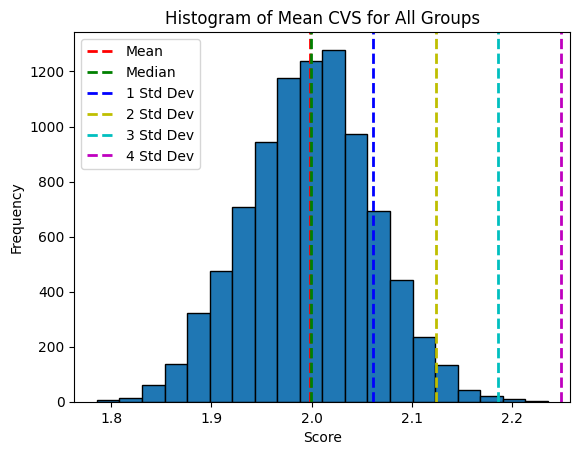

Resection: 19 nodes
Groups with Scores Below Threshold [1.937]: 1496
Best Score Range for Overlapping Groups: (2.1880449269100772, 2.250801235590702)
Best Overlap: 0.2818181818181818
Which is: 2.82/10 nodes


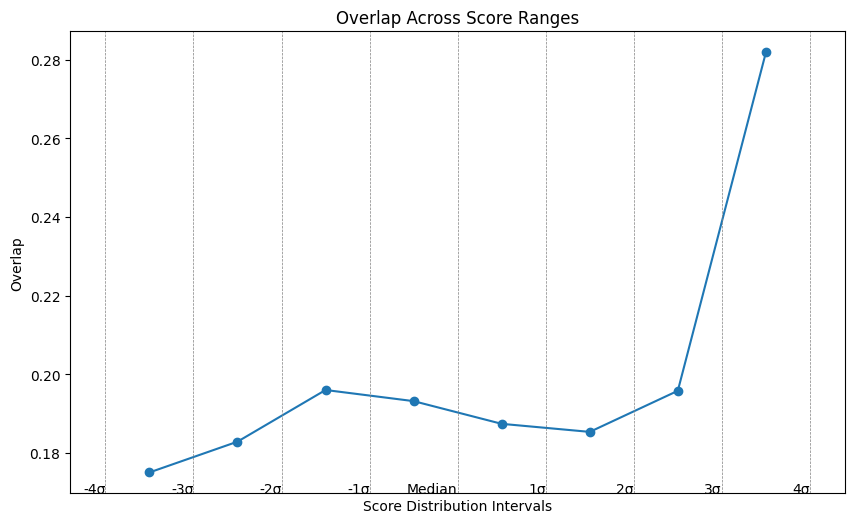

Subject: 2
4 True
Number of Rows with NaN Values: 0


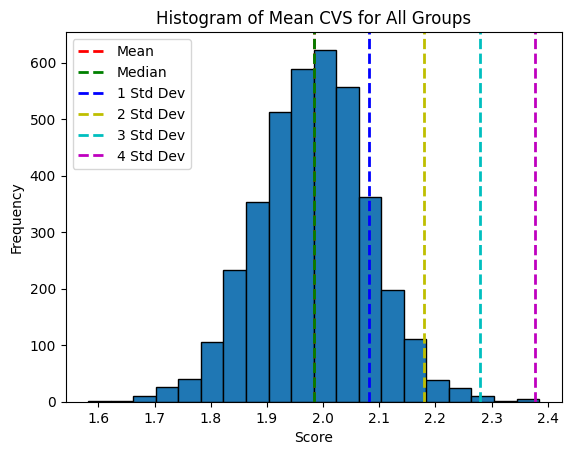

Resection: 22 nodes
Groups with Scores Below Threshold [1.886]: 595
Best Score Range for Overlapping Groups: (2.0829754485270002, 2.1813014266976585)
Best Overlap: 0.546555323590814
Which is: 2.73/5 nodes


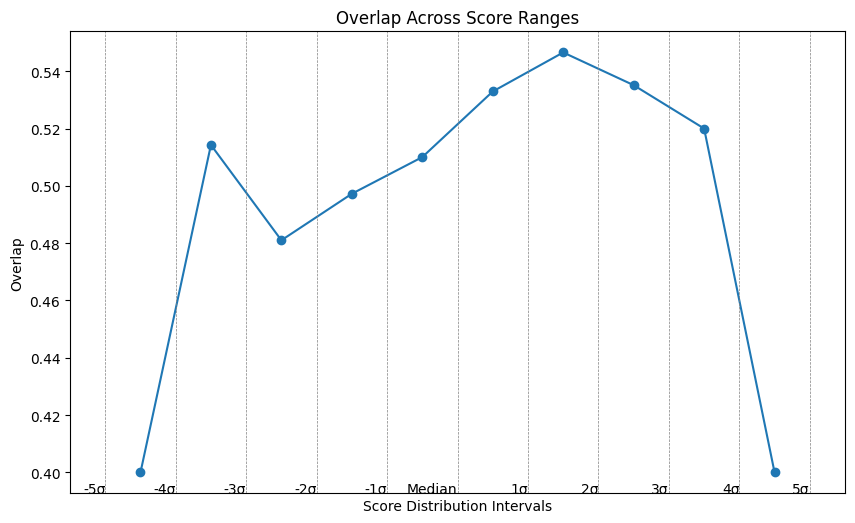

Subject: 3
13 True
Number of Rows with NaN Values: 0


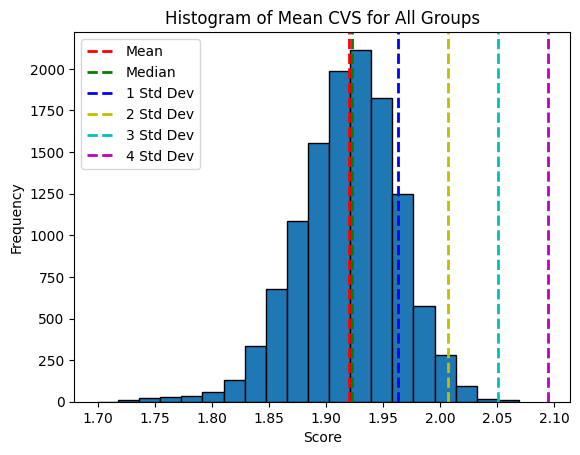

Resection: 18 nodes
Groups with Scores Below Threshold [1.879]: 2021
Best Score Range for Overlapping Groups: (1.8350013197834973, 1.8786402287542092)
Best Overlap: 0.15745192307692304
Which is: 2.20/14 nodes


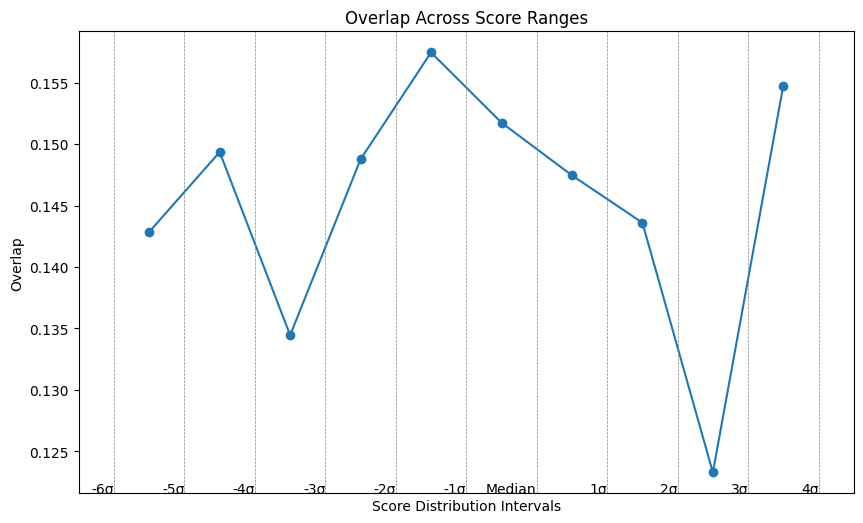

Subject: 4
11 True
Number of Rows with NaN Values: 0


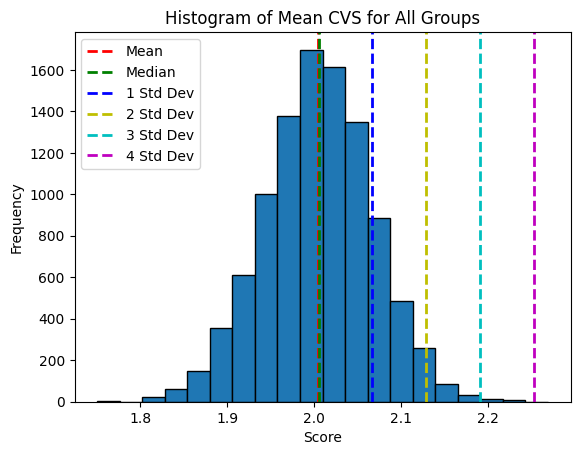

Resection: 38 nodes
Groups with Scores Below Threshold [1.943]: 1603
Best Score Range for Overlapping Groups: (2.253115524488332, 2.3151097948202426)
Best Overlap: 0.4166666666666667
Which is: 5.00/12 nodes


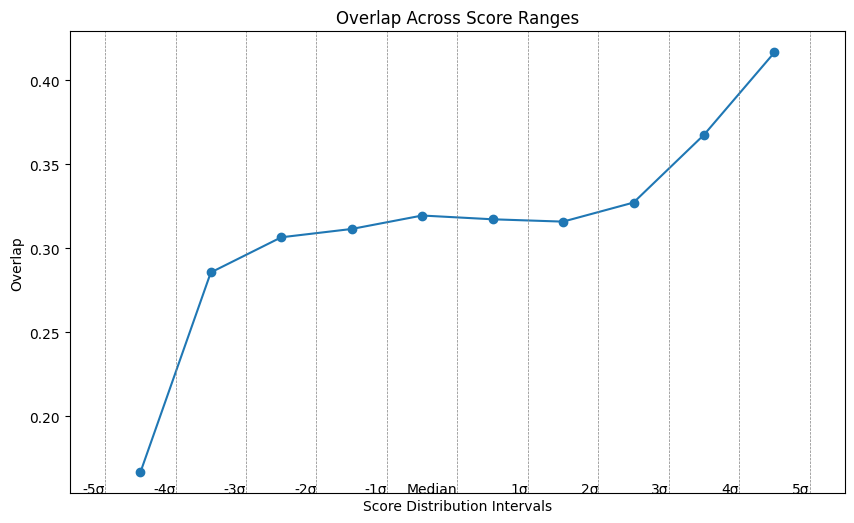

Subject: 5
6 True
Number of Rows with NaN Values: 0


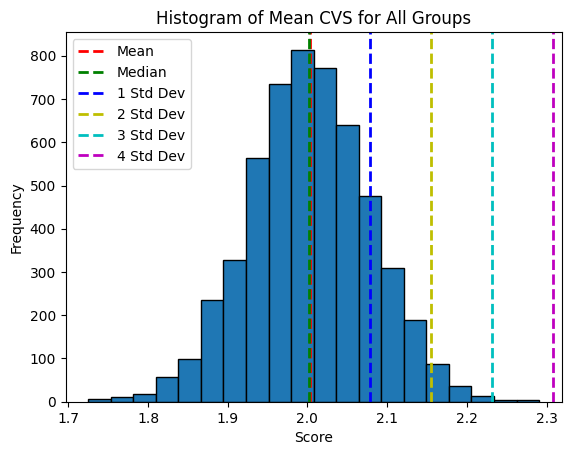

Resection: 8 nodes
Groups with Scores Below Threshold [1.925]: 812
Best Score Range for Overlapping Groups: (1.6961942994877435, 1.772623982382665)
Best Overlap: 0.219047619047619
Which is: 1.53/7 nodes


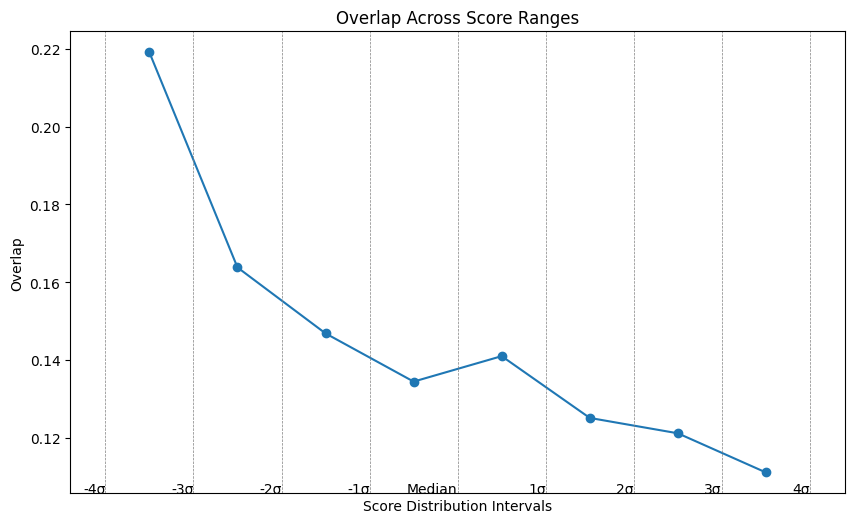

Subject: 6
3 False
Number of Rows with NaN Values: 0


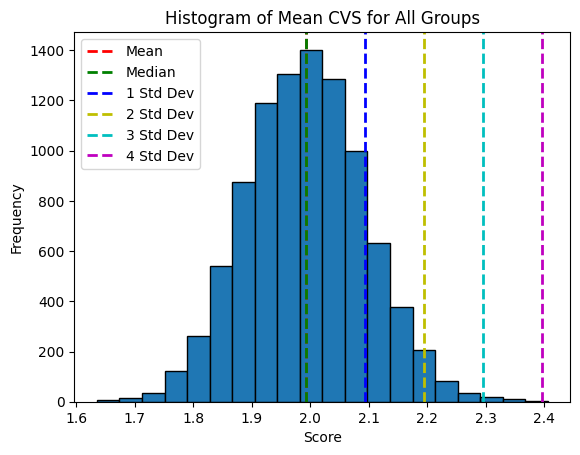

Resection: 4 nodes
Groups with Scores Below Threshold [1.891]: 1522
Best Score Range for Overlapping Groups: (1.587526697589415, 1.6885636945687608)
Best Overlap: 0.1111111111111111
Which is: 0.44/4 nodes


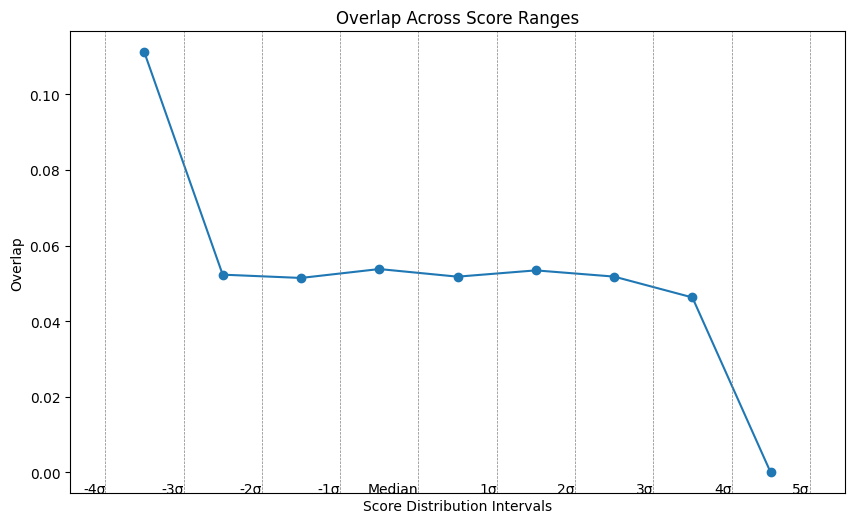

Subject: 7
9 True
Number of Rows with NaN Values: 0


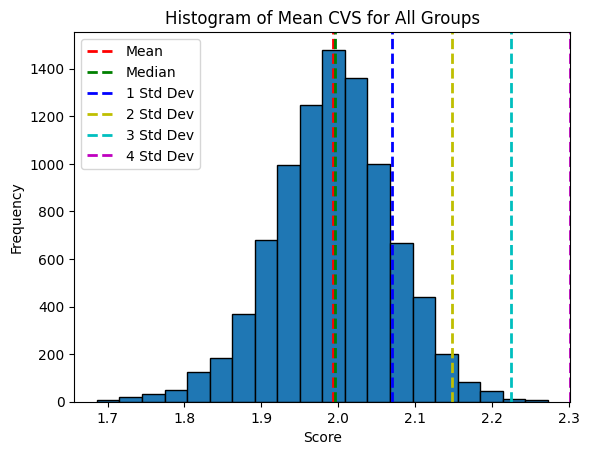

Resection: 70 nodes
Groups with Scores Below Threshold [1.918]: 1404
Best Score Range for Overlapping Groups: (1.6875255800857931, 1.764506599236407)
Best Overlap: 0.7538461538461538
Which is: 7.54/10 nodes


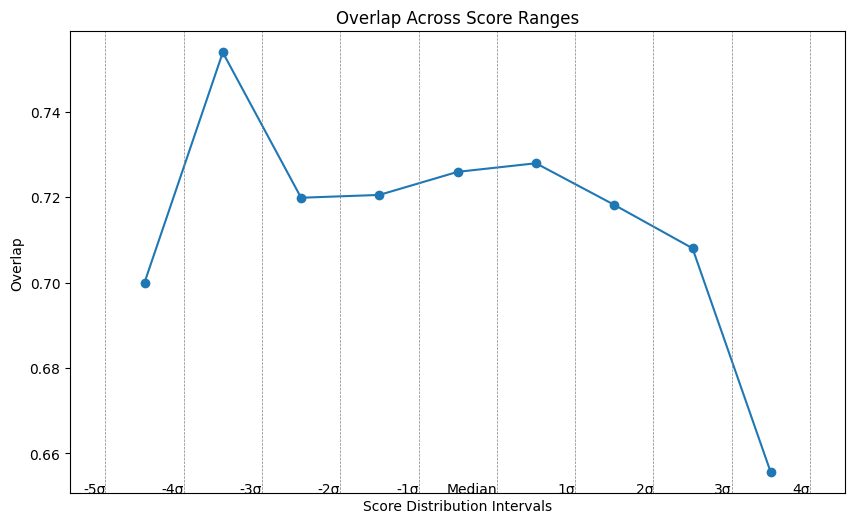

Subject: 8
10 True
Number of Rows with NaN Values: 0


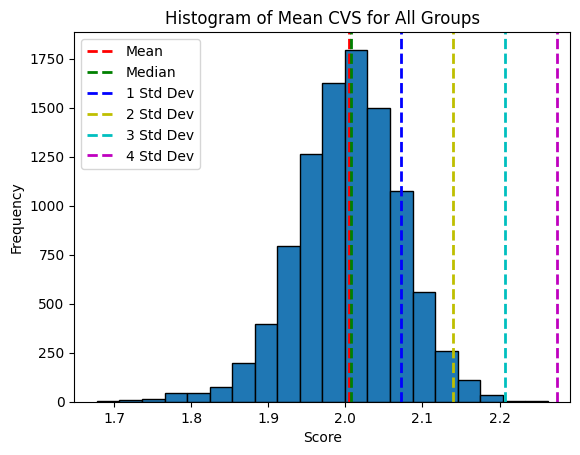

Resection: 22 nodes
Groups with Scores Below Threshold [1.939]: 1520
Best Score Range for Overlapping Groups: (2.0742095236610765, 2.141628665715846)
Best Overlap: 0.21926479560707746
Which is: 2.41/11 nodes


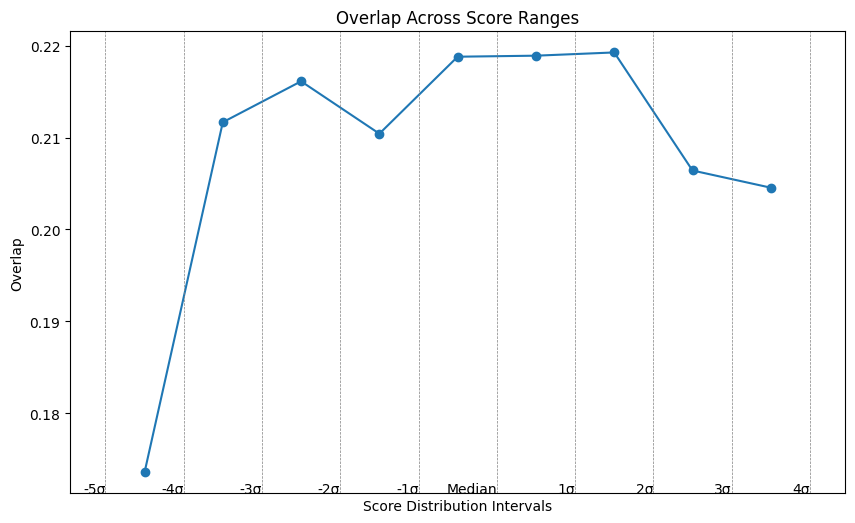

Subject: 9
4 True
Number of Rows with NaN Values: 0


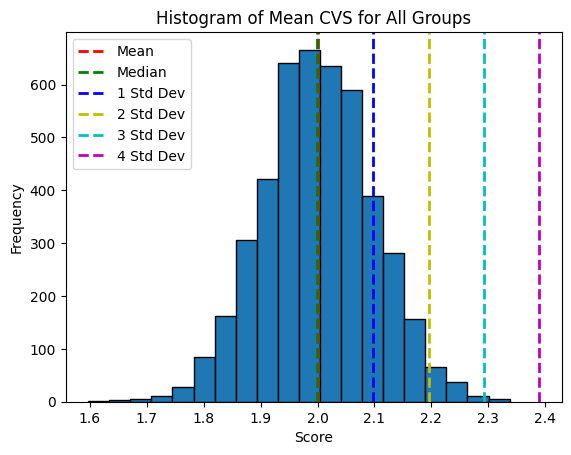

Resection: 15 nodes
Groups with Scores Below Threshold [1.903]: 706
Best Score Range for Overlapping Groups: (1.5140472703104995, 1.611178833782195)
Best Overlap: 0.4
Which is: 2.00/5 nodes


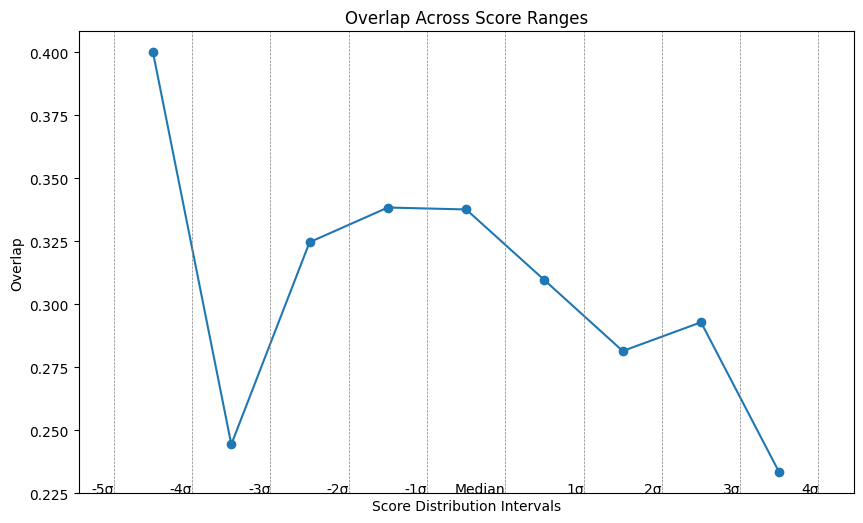

Subject: 10
9 True
Number of Rows with NaN Values: 0


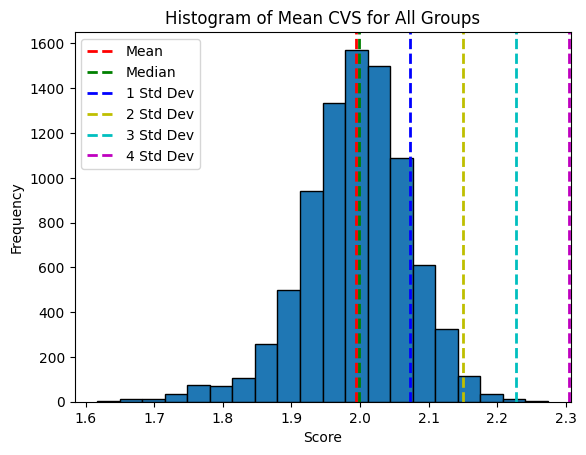

Resection: 15 nodes
Groups with Scores Below Threshold [1.921]: 1268
Best Score Range for Overlapping Groups: (2.2315246592672175, 2.3091965915733437)
Best Overlap: 0.175
Which is: 1.75/10 nodes


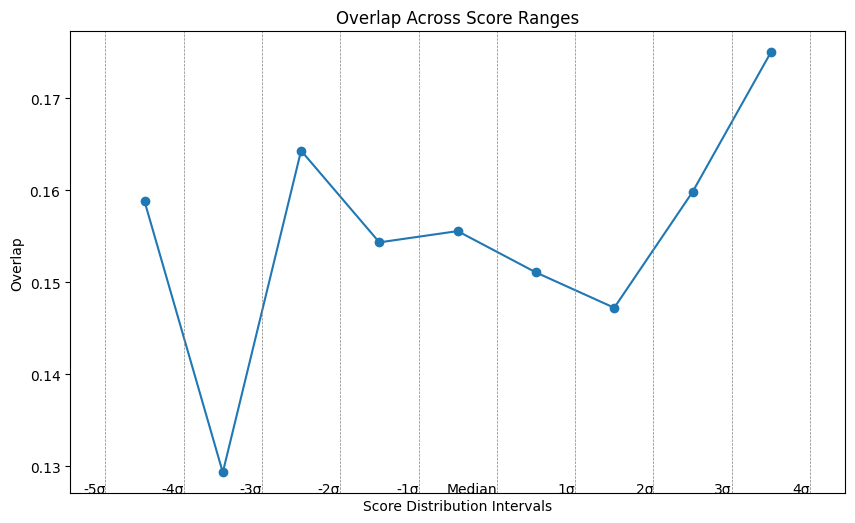

Subject: 11
8 True
Number of Rows with NaN Values: 0


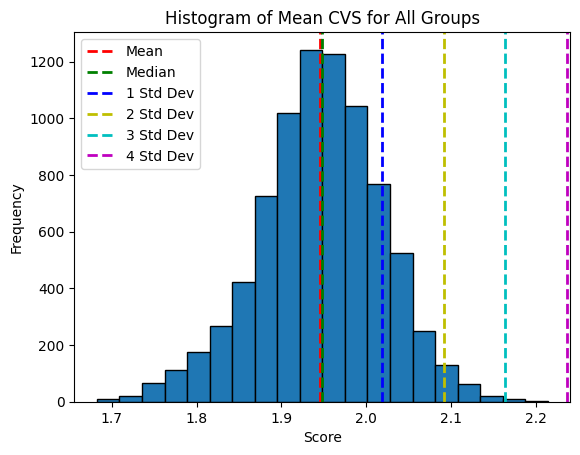

Resection: 21 nodes
Groups with Scores Below Threshold [1.876]: 1219
Best Score Range for Overlapping Groups: (1.6572967504367755, 1.7300473042092714)
Best Overlap: 0.27999999999999997
Which is: 2.52/9 nodes


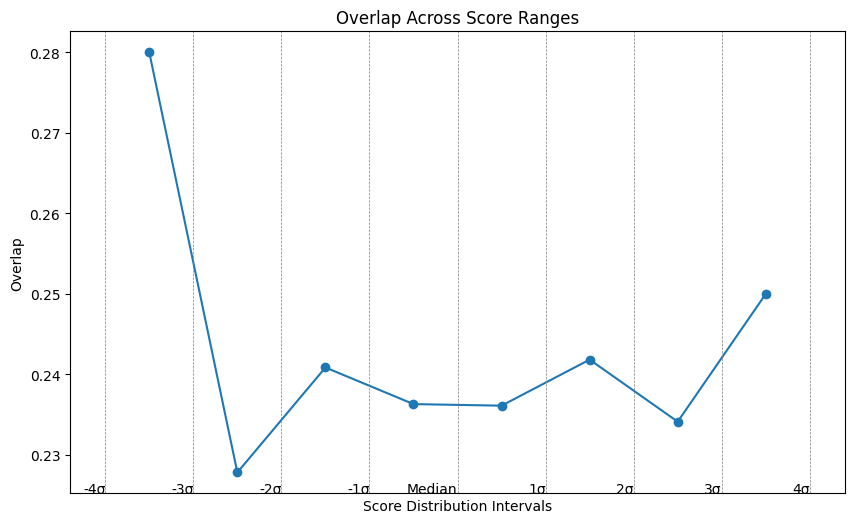

Subject: 12
1 False
Number of Rows with NaN Values: 0


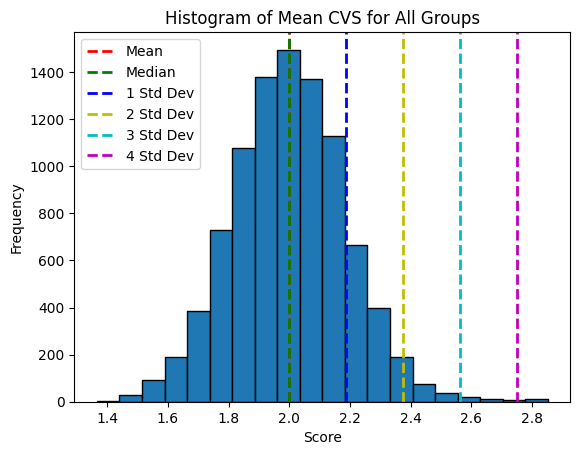

Resection: 1 nodes
Groups with Scores Below Threshold [1.812]: 1433
Best Score Range for Overlapping Groups: (2.5637960936549256, 2.751728126078053)
Best Overlap: 0.038461538461538464
Which is: 0.08/2 nodes


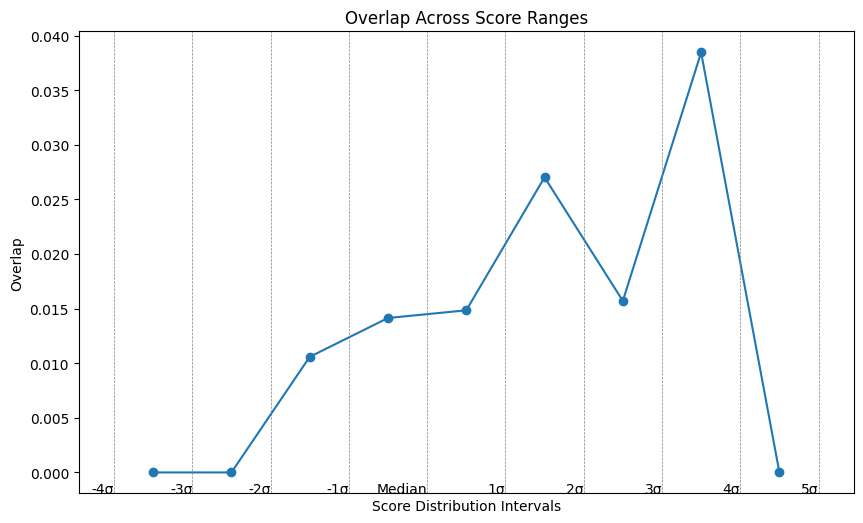

Subject: 13
8 True
Number of Rows with NaN Values: 0


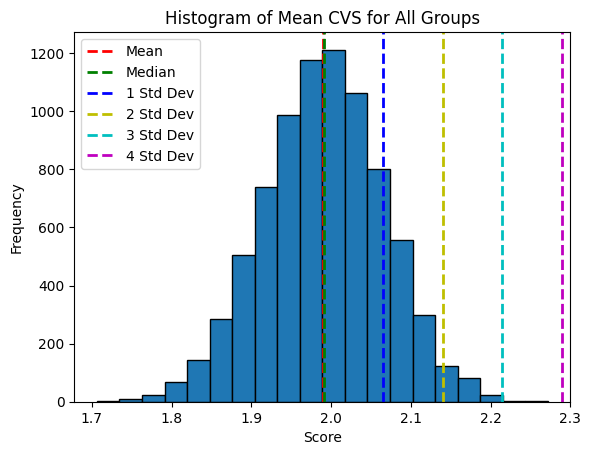

Resection: 38 nodes
Groups with Scores Below Threshold [1.917]: 1325
Best Score Range for Overlapping Groups: (1.6925233672576296, 1.7672658862050747)
Best Overlap: 0.494949494949495
Which is: 4.45/9 nodes


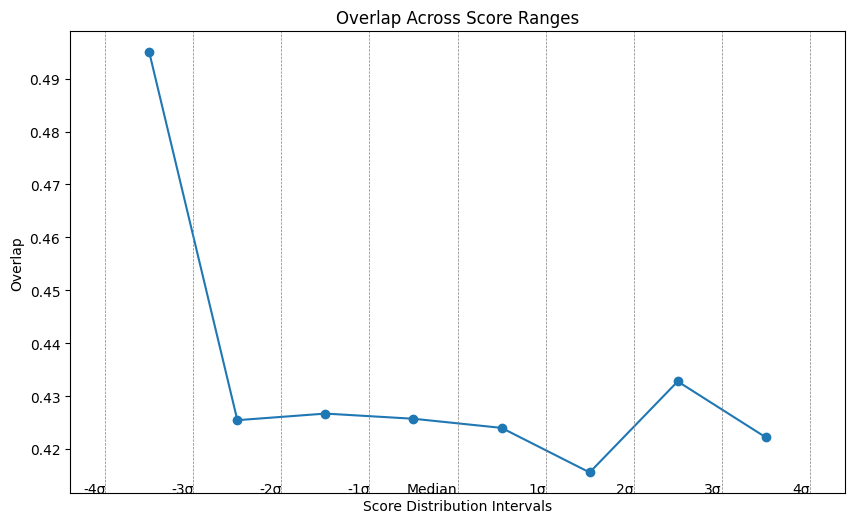

Subject: 14
4 False
Number of Rows with NaN Values: 0


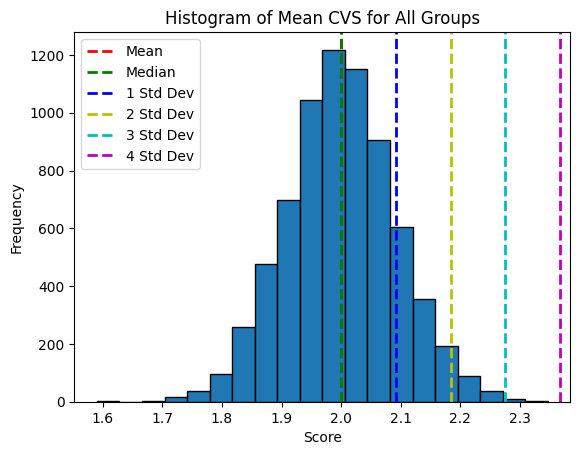

Resection: 5 nodes
Groups with Scores Below Threshold [1.907]: 1108
Best Score Range for Overlapping Groups: (1.723603298423039, 1.815532316202134)
Best Overlap: 0.0813793103448276
Which is: 0.41/5 nodes


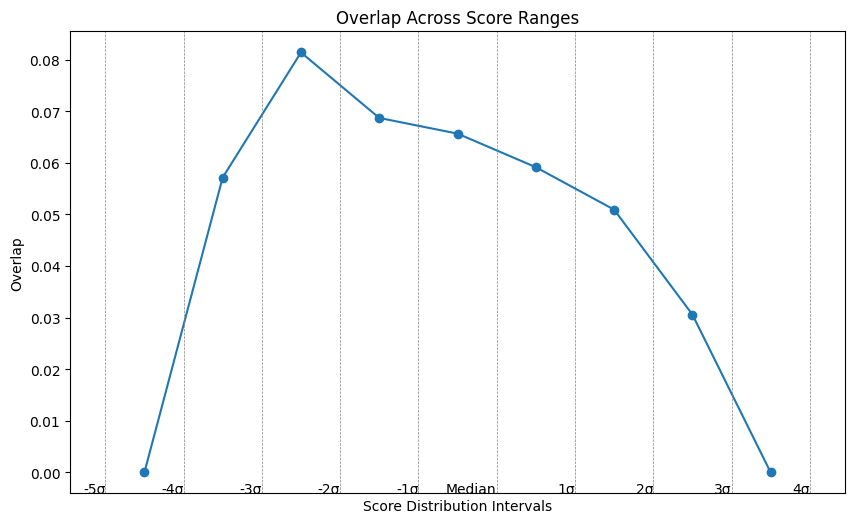

Subject: 15
9 True
Number of Rows with NaN Values: 0


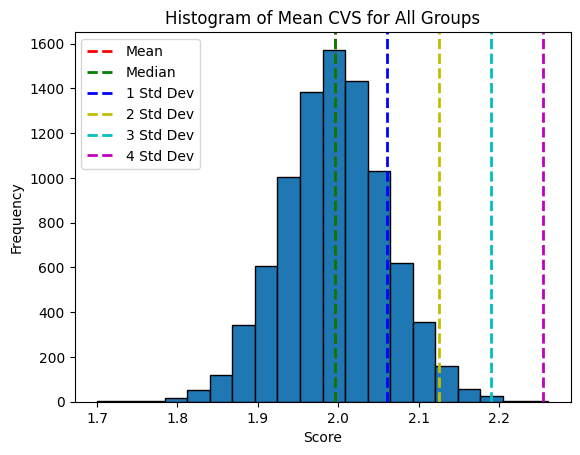

Resection: 10 nodes
Groups with Scores Below Threshold [1.932]: 1379
Best Score Range for Overlapping Groups: (2.2544611097833753, 2.319030209105243)
Best Overlap: 0.15000000000000002
Which is: 1.50/10 nodes


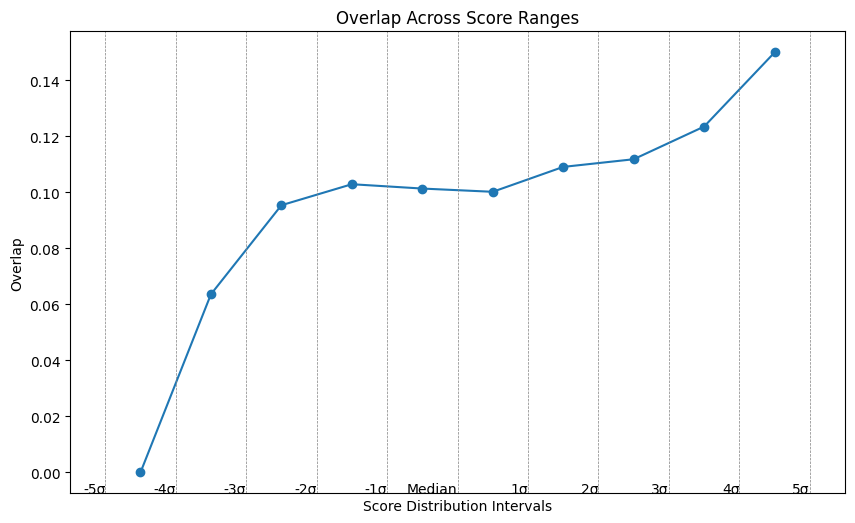

Subject: 16
9 True
Number of Rows with NaN Values: 0


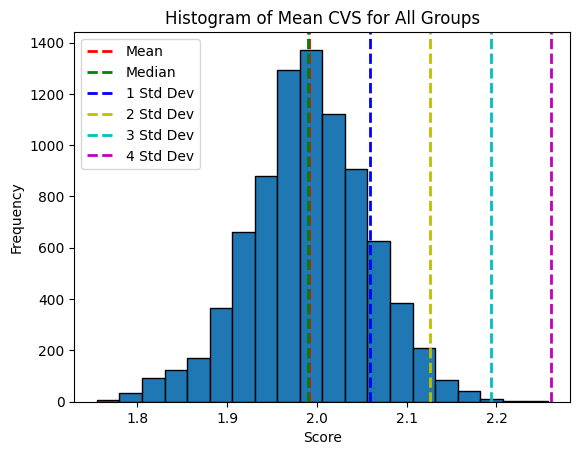

Resection: 13 nodes
Groups with Scores Below Threshold [1.923]: 1250
Best Score Range for Overlapping Groups: (1.85587196187459, 1.9232262733564034)
Best Overlap: 0.14676767676767677
Which is: 1.47/10 nodes


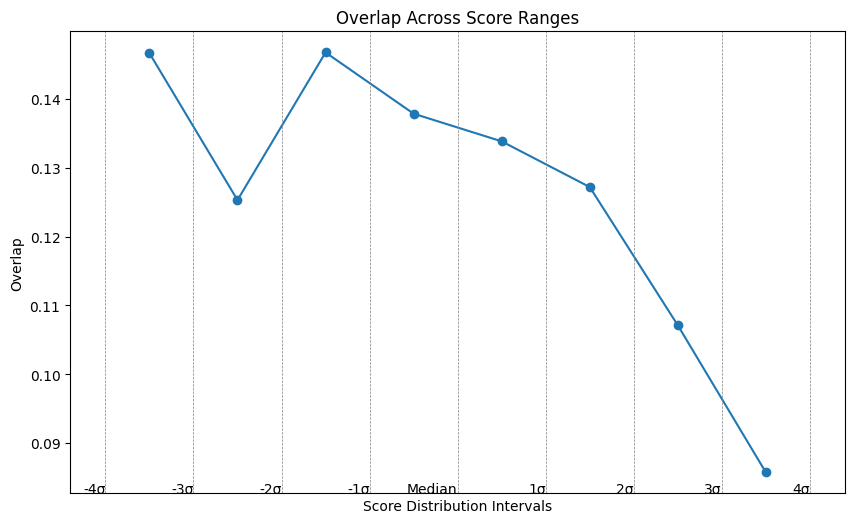

Subject: 17
11 True
Number of Rows with NaN Values: 0


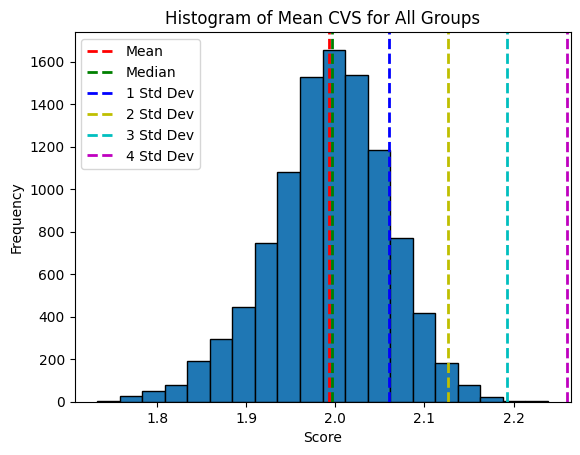

Resection: 29 nodes
Groups with Scores Below Threshold [1.930]: 1648
Best Score Range for Overlapping Groups: (2.1962884862517473, 2.2628581878854948)
Best Overlap: 0.2738095238095238
Which is: 3.29/12 nodes


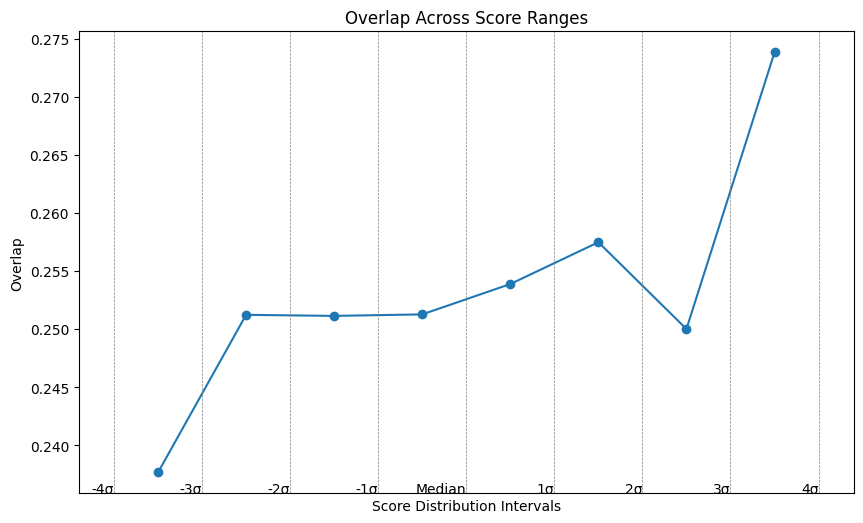

Subject: 18
16 True


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number of Rows with NaN Values: 181


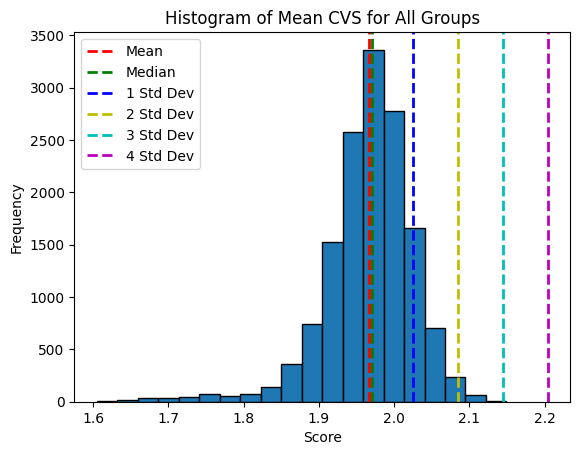

Resection: 56 nodes
Groups with Scores Below Threshold [1.912]: 1908
Best Score Range for Overlapping Groups: (1.5544393805393613, 1.6139803064626226)
Best Overlap: 0.4411764705882353
Which is: 7.50/17 nodes


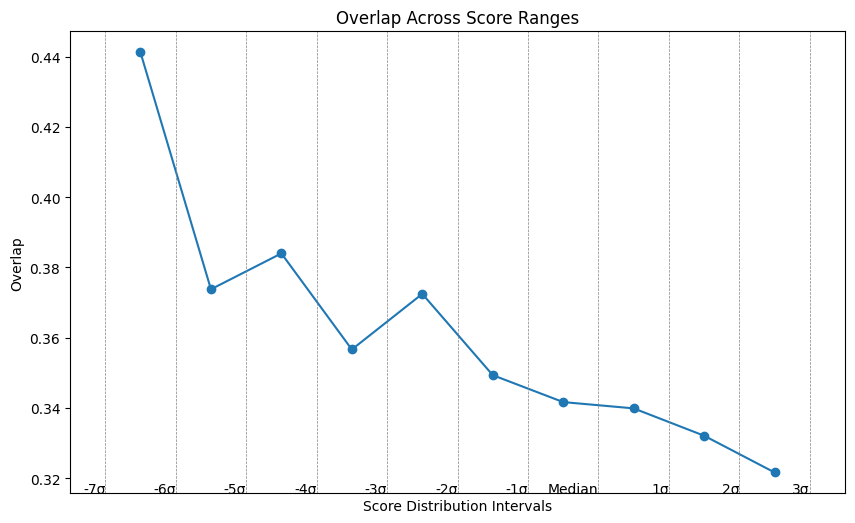

Subject: 19
5 True
Number of Rows with NaN Values: 0


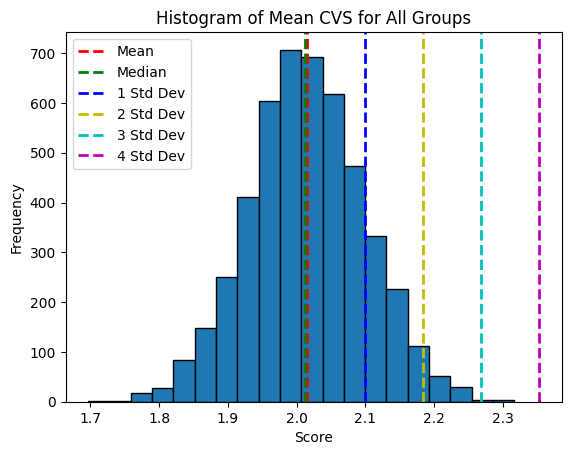

Resection: 22 nodes
Groups with Scores Below Threshold [1.929]: 706
Best Score Range for Overlapping Groups: (2.097475698276372, 2.1819298921672465)
Best Overlap: 0.4450980392156862
Which is: 2.67/6 nodes


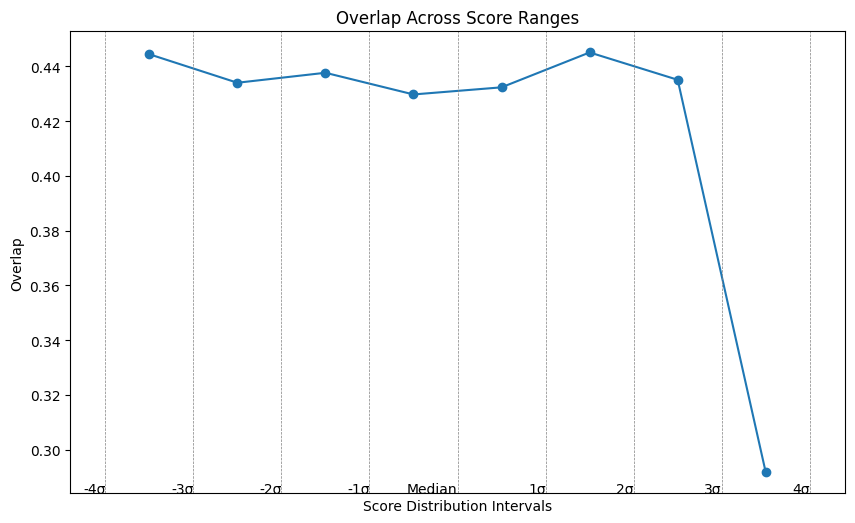

Subject: 20
6 False
Number of Rows with NaN Values: 0


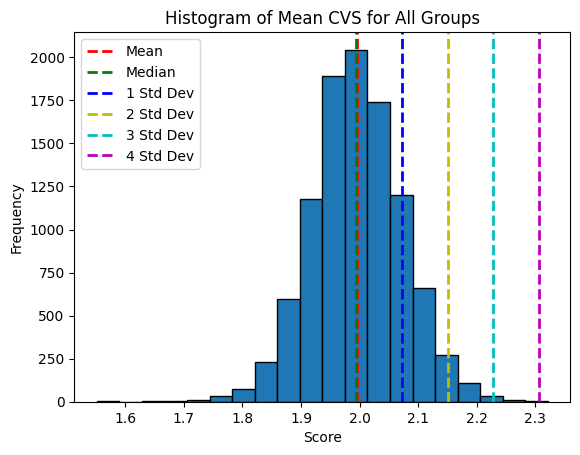

Resection: 7 nodes
Groups with Scores Below Threshold [1.916]: 1448
Best Score Range for Overlapping Groups: (2.3045674665272466, 2.382206566546879)
Best Overlap: 0.14285714285714285
Which is: 1.00/7 nodes


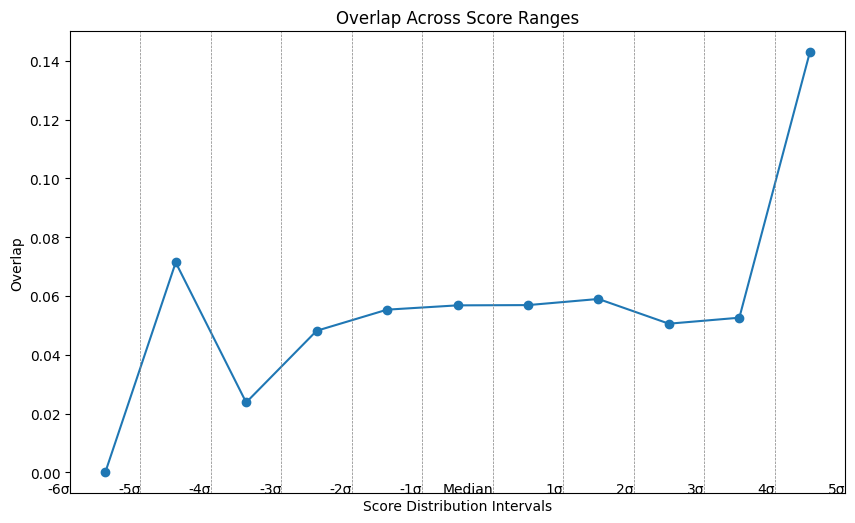

Subject: 21
9 True
Number of Rows with NaN Values: 0


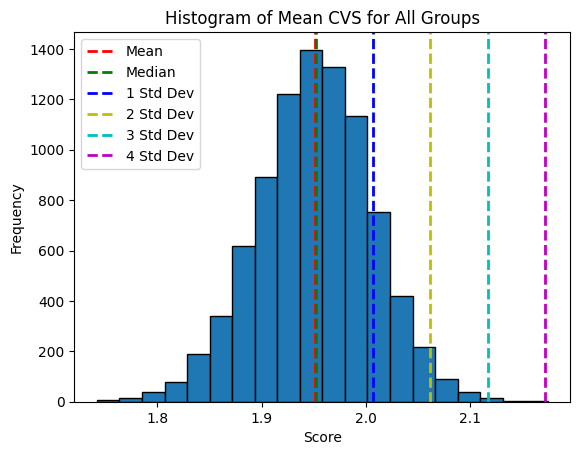

Resection: 24 nodes
Groups with Scores Below Threshold [1.897]: 1414
Best Score Range for Overlapping Groups: (2.172600924897691, 2.2277451310500456)
Best Overlap: 0.6
Which is: 6.00/10 nodes


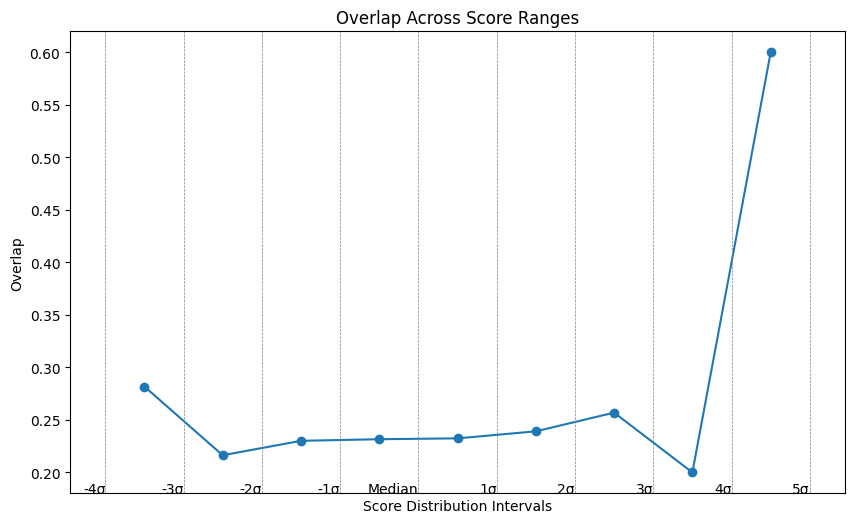

In [5]:
import math

# Set a specific random seed (e.g., 42 for reproducibility)
random_seed = 42
np.random.seed(random_seed)

print(measure)

for sub in subs:

    print(f"Subject: {sub}")
    df_sub = df[df['Subject'] == sub]

    r = 0.1
    group_size = 1
    if len(RESECTION[sub])>1:
        group_size = int(len(NODES[str(sub)])*r) if int(len(NODES[str(sub)])*r) < len(RESECTION[sub]) else len(RESECTION[sub])-1
    print(group_size, int(len(NODES[str(sub)])*r) < len(RESECTION[sub]))

    groups, nodes, mean_cvs = [],[],[]

    for i in range(100):

        group_labels = list(np.random.choice(NODES[str(sub)], size=group_size, replace=False))

        for node in NODES[str(sub)]:
            if node not in group_labels:
            # print("Analyzing Connectivity of Node:", node)
            # Split the Labels column into two nodes using '<->'
                split_labels = df_sub['Labels'].str.split('<->', expand=True)

                # Check if one node is the node and the other is in group_labels
                relevant_rows = df_sub[((split_labels[0] == node) & split_labels[1].isin(group_labels)) |
                                ((split_labels[1] == node) & split_labels[0].isin(group_labels))]

                # Calculate mean CVS values
                mean_cvs.append(list(relevant_rows['CVS'].apply(lambda x: MM(list(map(float, x.strip('[]').split()))))))
                groups.append(group_labels)
                nodes.append(node)

    data = {
        'Node': nodes,
        'Group': groups,
        'Score': [np.mean(x) for x in mean_cvs]}

    data = pd.DataFrame(data)

    # Count rows with NaN values
    nan_rows_count = data.isna().sum().sum()
    print("Number of Rows with NaN Values:", nan_rows_count)
    # Drop NaN rows
    data = data.dropna()

    plot_scores_hist(data)

    # Merge the 'Node' and 'Group' columns to create 'Group_full'
    data['Group_full'] = data.apply(lambda row: [row['Node']] + row['Group'], axis=1)

    # Sample resection list of nodes
    resection_nodes = RESECTION[sub]
    print(f"Resection: {len(resection_nodes)} nodes")

    # Find the common nodes (overlap)
    data['Overlap_with_Resection'] = data['Group_full'].apply(lambda row: compute_overlap(row, resection_nodes))

    # Define the threshold T_min/max as mean -/+ N * std
    N = 1
    T_min = data['Score'].median() - N * data['Score'].std()
    T_max = data['Score'].median() + N * data['Score'].std()

    # Filter nodes with a score above T_min and below T_max
    nodes_below_threshold = data[(data['Score'] < T_min)]
    nodes_above_threshold = data[(data['Score'] > T_min)]

    print(f"Groups with Scores Below Threshold [{T_min:.3f}]: {len(nodes_below_threshold)}")

    # Apply the function to each row
    data['Overlap_Percentage'] = data['Group_full'].apply(lambda row: compute_overlap_percentage(row, resection_nodes))

    # Calculate the median and standard deviation of 'Score'
    median_score = data['Score'].median()
    std_dev_score = data['Score'].std()

    # Define the number of standard deviations to consider
    num_std_devs = 7
    # Create score ranges relative to median and standard deviation
    score_ranges = []
    min_std, max_std = num_std_devs, -num_std_devs
    # Create an array of x-values with an offset
    x_values = []

    for i in range(-num_std_devs, num_std_devs):
        range_start = median_score + i * std_dev_score
        range_end = median_score + (i + 1) * std_dev_score

        # Check if there are score values in the range, and only add the range if there are values
        if any((range_start <= data['Score']) & (data['Score'] < range_end)):
            score_ranges.append((range_start, range_end))
            min_std = min(min_std, i)
            max_std = max(max_std, i)
            x_values.append(i+0.5)

    # Initialize lists to store overlap percentages and best score ranges
    overlap_percentages = []
    best_score_range = None
    best_overlap_percentage = 0.0

    for score_range in score_ranges:
        overlap_percentage = data[(data['Score'] >= score_range[0]) & (data['Score'] < score_range[1])]['Overlap_Percentage'].mean()
        overlap_percentages.append(overlap_percentage)

        if overlap_percentage > best_overlap_percentage:
            best_overlap_percentage = overlap_percentage
            best_score_range = score_range

    print("Best Score Range for Overlapping Groups:", best_score_range)
    print("Best Overlap:", best_overlap_percentage)
    print(f"Which is: {best_overlap_percentage*(group_size+1):.2f}/{group_size+1} nodes")

    # Plot overlap percentages across score ranges
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, overlap_percentages, marker='o', linestyle='-')
    plt.ylabel('Overlap')
    plt.xlabel('Score Distribution Intervals')
    plt.title('Overlap Across Score Ranges')

    # Set custom x-axis ticks at points between the ranges
    plt.xticks(x_values)
    # Add vertical lines for median and each standard deviation
    borders = x_values+[x_values[-1]+1]
    for k in [int(x-0.5) for x in borders]:
        label = 'Median' if k == 0 else f'{k}σ'
        plt.axvline(x=k, color='gray', linestyle='--', linewidth=0.5)
        plt.text(k, plt.ylim()[0], label, horizontalalignment='right')

    plt.xticks([])  # Remove x-axis ticks
    plt.show()


##### Below is an old approach; kept for now

In [ ]:
# Define the threshold as mean + N * std
N = 1

threshold = data['Score'].mean() + N * data['Score'].std()

# Get the groups with scores above the threshold
groups_above_threshold = data[data['Score'] > threshold]['Group']

print("Groups with Mean Scores Above Threshold:", (len(groups_above_threshold)))

In [ ]:
# Calculate the minimum required overlap (e.g., 50% of the resection list)
min_overlap = len(RESECTION[sub])*0.2

# Filter the groups_above_threshold that meet the minimum overlap condition
overlap_groups_with_min_overlap = [group for group in groups_above_threshold if sum(1 for label in RESECTION[sub] if label in group) >= min_overlap]
print("Groups with min_overlap with resection:", len(overlap_groups_with_min_overlap))

In [ ]:
# Extract the scores for the groups with at least min_overlap from the original DataFrame (data)
scores_for_overlap_groups = data[data['Group'].apply(lambda x: x in overlap_groups_with_min_overlap)]['Score']
print(scores_for_overlap_groups)

In [ ]:
# Plot the original histogram
plt.hist(data['Score'], bins=20, edgecolor='black', alpha=0.7, label='Score')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Mark the scores for the groups with at least min_overlap
for score in scores_for_overlap_groups:
    plt.axvline(score, color='r', linestyle='dashed', linewidth=2)

plt.show()

In [ ]:
# Print out nodes from the resection list that are present in overlap_groups_with_min_overlap
nodes_in_overlap = []

for node in RESECTION[sub]:
    if any(node in group for group in overlap_groups_with_min_overlap):
        nodes_in_overlap.append(node)

print("Nodes from Resection List Present in Overlap Groups:")
print(nodes_in_overlap)
print(len(nodes_in_overlap))